In [1]:
#Loading libraries
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pyhf
import scipy
from scipy import stats
import uproot3
import uproot
import math
import awkward as ak
import pickle
import csv
import copy

from importlib import reload

print("Successful!")

### Some root paths used by different users/devices
#     root_dir = "../../For_David/" for the default root directory used by David
#     root_dir = "/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/" # Filepath used on the FNAL cluster.
#     root_dir = "/Users/user/PhD/HPS_uboone_analysis/" # A filepath used for local running.
root_dir = "/Users/user/PhD/HPS_uboone_analysis/"
root_dir_fixed = root_dir

Successful!


# Purpose of script

This script loads BDT score histograms (both the counts and uncertainties) saved in .root files (the output from the Loadin_pkls_test notebook) and uses pyhf to caluclate the observed and expected limits using hypothesis testing. 

The observed and expected limits are then saved as .csv files that are read in to make: 
(i) "Brazil plots" at the end of this script.
(ii) A comparison plot of observed limits (Comparison_plot notebook).

Plot list: 1) Background uncertainty breakdown. 2) Observed and expected limit "Brazil plot"

## Loading histograms

In [2]:
# Enable this to used data from the reweighted data directory, and plot c_phi vs m_alp.
# To use conventional HPS data, set this to False.
REWEIGHTING = False
using_new_flux = False

Params_pyhf = {"Stats_only":False,
               "Use_flat_sys":False,
               "Num_bins_for_calc":6,
               "Use_part_only":True,
               "Use_toys":False,
               "Num_toys":1000,
               "Flat_bkg_overlay_frac":0.3,
               "Flat_bkg_dirt_frac":0.75,
               "Flat_bkg_EXT_frac":0.0,
               "Flat_sig_detvar":0.2, 
               "Scale_bkg_neutrino_flux": 1., # Scaling dirt and overlay fluxes
               "Scale_signal_flux": 1., # Scaling signal flux
               "Scale_kdar_signal_flux": 1., # Scaling signal flux from KDARs only
               "Scale_flux_uncertainty": 1., 
               "Signal_flux_error":0.3,
               "Overlay_detvar_frac":0.3,
               "Load_single_r1_file":False}



In [7]:
def New_Load_pyhf_files(filenames, Params_pyhf, location=root_dir+'BDT_output/', HNL_masses=[100, 150, 200]):
    loc_hists = location

    hist_dict_run1, hist_dict_run3, theta_dict = {}, {}, {}

    #Loading in the .root files
    for HNL_mass in HNL_masses:
        for shr in ["1shr", "2shr"]:
            for K in ["KDIF", "KDAR"]:
                name_ends = f"{HNL_mass}_{shr}_{K}"
                hist_dict_run1[name_ends] = uproot.open(loc_hists+f'run1_ALL_Capped_{name_ends}' + filenames)
                hist_dict_run3[name_ends] = uproot.open(loc_hists+f'run3_ALL_Capped_{name_ends}' + filenames)

                theta_dict[HNL_mass] = hist_dict_run1[name_ends]["theta"].values()[0] #assuming scaled theta is the same for all runs, only 1 value saved

    all_hists_list = ['bkg_overlay;1', 'bkg_dirt;1', 'bkg_EXT;1', 'signal;1', 'data;1', 'theta;1',  
                      'ppfx_uncertainty_frac;1', 'Genie_uncertainty_frac;1', 'Reinteraction_uncertainty_frac;1', 
                      'overlay_DetVar_uncertainty_frac;1', 'signal_DetVar_uncertainty_frac;1', "signal_KDAR_frac;1"]
    missing_hists = []
    for hist_name in all_hists_list:
        if hist_name not in hist_dict_run1[name_ends].keys(): missing_hists.append(hist_name)
    if len(missing_hists) == 0: print("No missing histograms in Run1")
    else:
        print("Missing hists for Run1 are: ")
        print(missing_hists)

    for hist_name in all_hists_list:
        if hist_name not in hist_dict_run3[name_ends].keys(): missing_hists.append(hist_name)
    if len(missing_hists) == 0: print("No missing histograms in Run3")
    else:
        print("Missing hists for Run3 are: ")
        print(missing_hists)

    print(theta_dict)
    print("Done")
    
    return hist_dict_run1, hist_dict_run3, theta_dict


In [8]:
all_HPS_masses = [100, 125, 130, 135, 140, 145, 150, 200]


c_phi_dict  = {
				100:	0.0027014149387605906, 
				125: 	0.0018106609327994778, 
                130:	0.0009990304425688081, 
                135:	4.52690931768051e-06, 
                140:	0.0008568518547569688, 
                145:	0.0014326989318147938, 
                150:	0.001798938228520414, 
                200:	0.002864767955135017
				}  


# Retrieving BDT scores from either reweighted or HPS directory

if using_new_flux == True:
	root_dir = root_dir_fixed + 'NewFlux/'

if REWEIGHTING == True:
	print('ALP')
	hist_dict_run1, hist_dict_run3, theta_dict = New_Load_pyhf_files(f".root", Params_pyhf, location=root_dir+"BDT_RW_output/", HNL_masses=all_HPS_masses)

else: 
	print('HPS')
	hist_dict_run1, hist_dict_run3, theta_dict = New_Load_pyhf_files(f".root", Params_pyhf, location=root_dir+"BDT_output/", HNL_masses=all_HPS_masses)

ALP
No missing histograms in Run1
No missing histograms in Run3
{100: 0.000536, 125: 0.00055, 130: 0.000554, 135: 0.000558, 140: 0.000563, 145: 0.000568, 150: 0.000573, 200: 0.000658}
Done


## Formatting the histograms

In [10]:
def add_hists_vals(hist_list):
    Total_hist = np.zeros_like(hist_list[0])
    for hist in hist_list:
        Total_hist += hist
    return Total_hist

def add_all_errors_dict(err_dict): #adds in quadrature, assuming all hists are same shape
    list_keys = list(err_dict.keys())
    Total_hist = np.zeros_like(err_dict[list_keys[0]])
    for i in range(len(err_dict[list_keys[0]])): #Looping over the bins
        for errs in err_dict.keys(): #Looping over the histograms
            Total_hist[i] += err_dict[errs][i]**2 #Adding error from each hist in quadrature
        Total_hist[i] = np.sqrt(Total_hist[i])
    return Total_hist

def add_all_errors(err_list): #adds in quadrature, assuming all hists are same shape
    Total_hist = np.zeros_like(err_list[0])
    for i in range(len(err_list[0])): #Looping over the bins
        for errs in err_list: #Looping over the histograms
            Total_hist[i] += errs[i]**2 #Adding error from each hist in quadrature
        Total_hist[i] = np.sqrt(Total_hist[i])
    return Total_hist

def Full_calculate_total_uncertainty(Params, hist_dict, zero_bins_errs): #Takes the dictionary of all root files
    """
    Given parameters, hist dict and zero bins error.
    Returns a dict of all types of error and individual sample values for use in models.
    """
    OVERLAY_VALS, DIRT_VALS, BEAMOFF_VALS = {}, {}, {}
    OVERLAY_STAT, DIRT_STAT, BEAMOFF_STAT = {}, {}, {}
    TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict = {}, {}
    BKG_STAT_ERR_dict, SIGNAL_STAT_ERR_dict = {}, {}
    BKG_DETVAR_ERR_dict, BKG_DIRT_ERR_dict, BKG_MULTISIM_ERR_dict = {}, {}, {}
    BKG_SHAPESYS_ERR_dict, SIGNAL_SHAPESYS_ERR_dict = {}, {}
    BKG_DETVAR_MULTISIM_dict = {}
    SIGNAL_DETVAR_ERR_dict = {}
    SIGNAL_NORMSYS_ERR_dict = {} #No normsys for this because currently background contributions are added together
    bkg_sample_names = ['bkg_overlay','bkg_EXT','bkg_dirt']
    overlay_sys_frac_flux = "ppfx_uncertainty_frac"
    overlay_sys_frac_names = ["Genie_uncertainty_frac","Reinteraction_uncertainty_frac","overlay_DetVar_uncertainty_frac"]
    for HNL_mass in hist_dict:
        bkg_stat_err_dict, bkg_sys_err_dict = {}, {} #Clean for each mass point
        
        OVERLAY_VALS[HNL_mass] = hist_dict[HNL_mass]['bkg_overlay'].values() * Params["Scale_bkg_neutrino_flux"]
        DIRT_VALS[HNL_mass] = hist_dict[HNL_mass]['bkg_dirt'].values() * Params["Scale_bkg_neutrino_flux"]
        BEAMOFF_VALS[HNL_mass] = hist_dict[HNL_mass]['bkg_EXT'].values()
        OVERLAY_STAT[HNL_mass] = np.add(hist_dict[HNL_mass]['bkg_overlay'].errors(), zero_bins_errs[HNL_mass]['bkg_overlay'])
        DIRT_STAT[HNL_mass] = np.add(hist_dict[HNL_mass]['bkg_dirt'].errors(), zero_bins_errs[HNL_mass]['bkg_dirt'])
        BEAMOFF_STAT[HNL_mass] = np.add(hist_dict[HNL_mass]['bkg_EXT'].errors(), zero_bins_errs[HNL_mass]['bkg_EXT'])
        
        for name in bkg_sample_names:
            bkg_stat_err_dict[name]=np.add(hist_dict[HNL_mass][name].errors(), zero_bins_errs[HNL_mass][name])
        sig_stat_err = np.add(hist_dict[HNL_mass]['signal'].errors(), zero_bins_errs[HNL_mass]['signal'])
        
        if Params["Stats_only"] == True: #Set all systematic errors to zero
            for name in bkg_sample_names:
                bkg_sys_err_dict[name] = np.zeros_like(hist_dict[HNL_mass][name].errors())

            overlay_sys_dict = {}

            overlay_sys_dict[overlay_sys_frac_flux] = np.zeros_like(hist_dict[HNL_mass][overlay_sys_frac_flux].values())
                  
            for sys in overlay_sys_frac_names:
                overlay_sys_dict[sys] = np.zeros_like(hist_dict[HNL_mass][sys].values())

            sig_sys_err =  np.zeros_like(hist_dict[HNL_mass]['signal'].errors())
            sig_detvar_err = np.zeros_like(hist_dict[HNL_mass]['signal'].values())
            sig_flux_err = np.zeros_like(hist_dict[HNL_mass]['signal'].values())
        
        elif Params["Use_flat_sys"] == True:
            for name in bkg_sample_names:
                bkg_sys_err_dict[name] = hist_dict[HNL_mass][name].values()*Params["Flat_"+name+"_frac"]
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*hist_dict[HNL_mass]["signal_KDAR_frac"].to_numpy()[0]
            sig_detvar_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_detvar"]
            sig_sys_err = np.sqrt(sig_flux_err**2 + sig_detvar_err**2)
       
        #This is using the fully evaluated uncertainties
        elif Params["Use_flat_sys"] == False: 
            overlay_sys_dict = {}

            overlay_sys_dict[overlay_sys_frac_flux] = hist_dict[HNL_mass][overlay_sys_frac_flux].values()*hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Scale_flux_uncertainty"]
                  
            # print((hist_dict[HNL_mass][overlay_sys_frac_flux].values()*hist_dict[HNL_mass]['bkg_overlay'].values())[0])
            # print(overlay_sys_dict[overlay_sys_frac_flux][0])
            
            for sys in overlay_sys_frac_names:
                overlay_sys_dict[sys] = hist_dict[HNL_mass][sys].values()*hist_dict[HNL_mass]['bkg_overlay'].values()

            bkg_sys_err_dict['bkg_overlay'] = add_all_errors_dict(overlay_sys_dict)
            bkg_sys_err_dict['bkg_EXT'] = np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors())
            bkg_sys_err_dict['bkg_dirt'] = hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_bkg_dirt_frac"]
            
            # sig_detvar_err = hist_dict[HNL_mass]["signal_DetVar_uncertainty"].values()
            sig_detvar_err = hist_dict[HNL_mass]["signal_DetVar_uncertainty_frac"].values()*hist_dict[HNL_mass]['signal'].values()
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*hist_dict[HNL_mass]["signal_KDAR_frac"].to_numpy()[0]
            sig_sys_err = add_all_errors([sig_detvar_err,sig_flux_err])
            
        #Evaluating final stat+sys errors    
        bkg_stat_plus_sys_dict={}
        for name in bkg_sample_names:
            bkg_stat_plus_sys_dict[name]=add_all_errors([bkg_stat_err_dict[name],bkg_sys_err_dict[name]]) 
        
        total_bkg_err = add_all_errors_dict(bkg_stat_plus_sys_dict) #Now adding the errors of overlay, EXT and dirt in quadrature
        total_sig_err = add_all_errors([sig_stat_err,sig_sys_err])
        
        TOT_BKG_ERR_dict[HNL_mass] = total_bkg_err
        TOT_SIGNAL_ERR_dict[HNL_mass] = total_sig_err
        
        BKG_STAT_ERR_dict[HNL_mass] = add_all_errors_dict(bkg_stat_err_dict)
        BKG_SHAPESYS_ERR_dict[HNL_mass] = add_all_errors_dict(bkg_sys_err_dict)
        BKG_DETVAR_ERR_dict[HNL_mass] = overlay_sys_dict["overlay_DetVar_uncertainty_frac"]
        BKG_DIRT_ERR_dict[HNL_mass] = bkg_sys_err_dict['bkg_dirt']
        BKG_MULTISIM_ERR_dict[HNL_mass] = add_all_errors([overlay_sys_dict["ppfx_uncertainty_frac"],
                                                          overlay_sys_dict["Genie_uncertainty_frac"],
                                                          overlay_sys_dict["Reinteraction_uncertainty_frac"]])
        BKG_DETVAR_MULTISIM_dict[HNL_mass] = add_all_errors([BKG_DETVAR_ERR_dict[HNL_mass], BKG_MULTISIM_ERR_dict[HNL_mass]])
        
        SIGNAL_STAT_ERR_dict[HNL_mass] = sig_stat_err
        SIGNAL_SHAPESYS_ERR_dict[HNL_mass] = sig_detvar_err
        SIGNAL_DETVAR_ERR_dict[HNL_mass] = sig_detvar_err
    TOT_ERR_DICT = {}
    TOT_ERR_DICT["OVERLAY_VALS"], TOT_ERR_DICT["DIRT_VALS"], TOT_ERR_DICT["BEAMOFF_VALS"] = OVERLAY_VALS, DIRT_VALS, BEAMOFF_VALS
    TOT_ERR_DICT["OVERLAY_STAT"], TOT_ERR_DICT["DIRT_STAT"], TOT_ERR_DICT["BEAMOFF_STAT"] = OVERLAY_STAT, DIRT_STAT, BEAMOFF_STAT
    TOT_ERR_DICT["TOT_BKG_ERR"], TOT_ERR_DICT["TOT_SIGNAL_ERR"] = TOT_BKG_ERR_dict, TOT_SIGNAL_ERR_dict
    TOT_ERR_DICT["BKG_STAT"], TOT_ERR_DICT["BKG_SHAPESYS"] = BKG_STAT_ERR_dict, BKG_SHAPESYS_ERR_dict
    TOT_ERR_DICT["BKG_DETVAR"], TOT_ERR_DICT["BKG_DIRT"], TOT_ERR_DICT["BKG_MULTISIM"] = BKG_DETVAR_ERR_dict, BKG_DIRT_ERR_dict, BKG_MULTISIM_ERR_dict
    TOT_ERR_DICT["BKG_DETVAR_MULTISIM"] = BKG_DETVAR_MULTISIM_dict
    TOT_ERR_DICT["SIGNAL_STAT"], TOT_ERR_DICT["SIGNAL_SHAPESYS"] = SIGNAL_STAT_ERR_dict, SIGNAL_SHAPESYS_ERR_dict
    TOT_ERR_DICT["SIGNAL_DETVAR"] = SIGNAL_DETVAR_ERR_dict
    
    return TOT_ERR_DICT

def False_zero_bins(hist_dict):
    """
    This will set all "zero bin" errors as zero, i.e not accounting for them. 
    """
    print("Not accounting for zero bin count errors.")
    zero_bins_errors = {}
    bkg_sample_names = ['bkg_overlay','bkg_EXT','bkg_dirt']
    
    for HNL_mass in hist_dict:
        zero_bins_per_mass = {}
        for bkg in bkg_sample_names:
            zero_bins_per_mass[bkg] = np.zeros_like(hist_dict[HNL_mass][bkg].values())
                    
        zero_bins_per_mass["signal"] = np.zeros_like(hist_dict[HNL_mass]["signal"].values())
        zero_bins_errors[HNL_mass] = zero_bins_per_mass
        
    return zero_bins_errors


In [11]:

zero_bins_errors_run1 = False_zero_bins(hist_dict_run1)
zero_bins_errors_run3 = False_zero_bins(hist_dict_run3)

TOT_R1_ERR = Full_calculate_total_uncertainty(Params_pyhf, hist_dict_run1, zero_bins_errors_run1)
TOT_R3_ERR = Full_calculate_total_uncertainty(Params_pyhf, hist_dict_run3, zero_bins_errors_run3)

Not accounting for zero bin count errors.
Not accounting for zero bin count errors.


In [12]:
if Params_pyhf["Scale_flux_uncertainty"] != 1:
    print("works",Params_pyhf["Scale_flux_uncertainty"])

In [13]:
def Add_bkg_hists_make_signal(hist_dict, Params_pyhf):
    """
    Input dict of histgrams.
    Returns dicts of total BKG and total signal.
    """
    BKG_dict, SIGNAL_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_hists = [hist_dict[HNL_mass]['bkg_EXT'].values(), hist_dict[HNL_mass]['bkg_overlay'].values()*Params_pyhf['Scale_bkg_neutrino_flux'], hist_dict[HNL_mass]['bkg_dirt'].values()*Params_pyhf['Scale_bkg_neutrino_flux']]
        
        total_bkg = add_hists_vals(bkg_hists)
        BKG_dict[HNL_mass] = total_bkg
        SIGNAL_dict[HNL_mass] = hist_dict[HNL_mass]['signal'].values()*Params_pyhf['Scale_signal_flux']
 
    return BKG_dict, SIGNAL_dict

def remove_part_hist(hist_list, numbins):
        length = len(hist_list)
        slice_at = length - int(numbins)
        if slice_at < 0:
            # print("Trying to use greater number of bins than available, using full dist.")
            return hist_list
        else:
            sliced_hist = hist_list[slice_at:]
            return sliced_hist

def Make_into_lists(Params, BKG_dict, SIGNAL_dict, TOT_ERR_dict):
    """
    Takes parameters, the dicts of bkg and signal values and the error dict.
    Returns an output dict with bkg vals, signal vals and error vals all as lists with the correct number of bins.
    """
    BKG_dict_FINAL, SIGNAL_dict_FINAL= {}, {}
    ERR_dict_FINAL = {}
    for HNL_mass in BKG_dict:
        ERR_list_dict = {}
        BKG = np.ndarray.tolist(BKG_dict[HNL_mass])
        SIGNAL = np.ndarray.tolist(SIGNAL_dict[HNL_mass]*Params["Scale_signal_flux"])
        
        if HNL_mass[-4:] == "KDAR":
            SIGNAL = np.ndarray.tolist(SIGNAL_dict[HNL_mass]*Params["Scale_signal_flux"]*Params["Scale_kdar_signal_flux"])

        for err_dict in TOT_ERR_dict:
            ERR_list_dict[err_dict]=np.ndarray.tolist(TOT_ERR_dict[err_dict][HNL_mass])
        if Params["Use_part_only"] == True:
            numbins = Params["Num_bins_for_calc"] #Number of bins in signal region to use for CLs calc
            BKG=remove_part_hist(BKG, numbins)
            SIGNAL=remove_part_hist(SIGNAL, numbins)
            for err_dict in ERR_list_dict:
                ERR_list_dict[err_dict]=remove_part_hist(ERR_list_dict[err_dict], numbins)
            
        BKG_dict_FINAL[HNL_mass] = BKG
        SIGNAL_dict_FINAL[HNL_mass] = SIGNAL
        ERR_dict_FINAL[HNL_mass] = ERR_list_dict

    # output_dict = {"BKG_dict":BKG_dict_FINAL, "SIGNAL_dict":SIGNAL_dict_FINAL}
    output_dict = {"TOT_BKG_VALS":BKG_dict_FINAL, "TOT_SIGNAL_VALS":SIGNAL_dict_FINAL}

    for err_dict in TOT_ERR_dict:
        new_err_dict_placeholder = {}
        for HNL_mass in BKG_dict:
            new_err_dict_placeholder[HNL_mass] = ERR_dict_FINAL[HNL_mass][err_dict]
        
        output_dict.update({err_dict:new_err_dict_placeholder})
        
    return output_dict

def append_list_of_lists(input_list):
        output_list = []
        for i in range(len(input_list)):
            output_list = output_list + input_list[i]
        return output_list

def Append_four_channels(Run_output):
    
    Merged_dict = {}
    Total_merged = {}
    
    all_keys = list(Run_output.keys())
    first_key = all_keys[0]
    
    all_hists = list(Run_output[first_key].keys())
    all_masses=[]
    for key in all_hists:
        # all_masses.append(key.split("_")[0])
        all_masses.append(int(key.split("_")[0]))
        
    unique_masses = set(all_masses)
        
    merge_list = ["1shr_KDIF", "1shr_KDAR", "2shr_KDIF", "1shr_KDAR"]
    
    for key in all_keys:
        Merged_dict={}
        for mass_val in unique_masses:
            list_placeholder = []
            for name in merge_list:
                list_placeholder.append(Run_output[key][f"{mass_val}_{name}"])
            Merged = append_list_of_lists(list_placeholder)
            Merged_dict[mass_val]=Merged
        Total_merged[key] = Merged_dict
        
    return Total_merged

def Create_final_appended_runs_dict(list_input_dicts):

    Total_dict = {}
    all_keys = list(list_input_dicts[0].keys())
    first_key = all_keys[0]
    for HNL_mass in list_input_dicts[0][first_key]:
    # for HNL_mass in Constants.HNL_mass_samples:
        Appended_dict = {}
        # HNL_mass_val = HNL_mass.split("_")[0]
        HNL_mass_val = HNL_mass
        for dict_type in list_input_dicts[0].keys():
            list_placeholder = []
            for input_dict in list_input_dicts: #This loops over the dicts for different runs
                list_placeholder.append(input_dict[dict_type][HNL_mass]) 
            Appended = append_list_of_lists(list_placeholder)
            Appended_dict[dict_type] = Appended
        Total_dict[HNL_mass] = Appended_dict
        
    return Total_dict

def add_data(Total_dict, hists, numbins):
    """
    Given total dict, hist dict and number of bins.
    Returns total dict with data added for a single run.
    """
    for HNL_mass in Total_dict:
        hist_placeholder = list(hists[HNL_mass]["data"].values())
        hist_data = remove_part_hist(hist_placeholder, numbins)
        Total_dict[HNL_mass]["data"]=hist_data
    return Total_dict

def add_data_appended(Total_dict, hists_r1, hists_r3, numbins):
    """
    Given Total dict, r1 and r3 dicts and number of bins.
    Returns new Total dict with data added for both runs. 
    """
    for HNL_mass in Total_dict:
        r1_hist_placeholder = list(hists_r1[HNL_mass]["data"].values())
        r3_hist_placeholder = list(hists_r3[HNL_mass]["data"].values())
        r1_hist = remove_part_hist(r1_hist_placeholder, numbins)
        r3_hist = remove_part_hist(r3_hist_placeholder, numbins)
        appended = r1_hist+r3_hist
        Total_dict[HNL_mass]["data"]=appended
    return Total_dict

def add_data_merged_appended(Total_dict, hists_r1, hists_r3, numbins):
    """
    Given Total dict, r1 and r3 dicts and number of bins.
    Returns new Total dict with data added for both runs. 
    """
    merge_list = ["1shr_KDIF", "1shr_KDAR", "2shr_KDIF", "1shr_KDAR"]
    
    r1_merged, r3_merged = {}, {}
    Total_merged = {}
    
    all_keys = list(hists_r1.keys())
    first_key = all_keys[0]
    
    all_masses=[]
    #Looping over 100_KDIF_1shr
    for key in all_keys:
        all_masses.append(key.split("_")[0])
        
    unique_masses = set(all_masses)
        
    merge_list = ["1shr_KDIF", "1shr_KDAR", "2shr_KDIF", "1shr_KDAR"]
    #Looping over 100_KDIF_1shr
    for key in all_keys:
        r1_merged, r3_merged = {}, {}
        for mass_val in unique_masses:
            list_placeholder_r1, list_placeholder_r3 = [], []
            for name in merge_list:
                vals_r1 = hists_r1[f"{mass_val}_{name}"]["data"].values()
                vals_r3 = hists_r3[f"{mass_val}_{name}"]["data"].values()
                r1_hist_sliced = remove_part_hist(list(vals_r1), numbins)
                r3_hist_sliced = remove_part_hist(list(vals_r3), numbins)
                list_placeholder_r1.append(r1_hist_sliced)
                list_placeholder_r3.append(r3_hist_sliced)
            Merged_r1 = append_list_of_lists(list_placeholder_r1)
            Merged_r3 = append_list_of_lists(list_placeholder_r3)
            # Merged_dict[mass_val]=Merged
            r1_merged[mass_val]=Merged_r1
            r3_merged[mass_val]=Merged_r3
    
    for HNL_mass in Total_dict:
        r1_hist_placeholder = list(r1_merged[str(HNL_mass)])
        r3_hist_placeholder = list(r3_merged[str(HNL_mass)])
        # r1_hist = remove_part_hist(r1_hist_placeholder, numbins)
        # r3_hist = remove_part_hist(r3_hist_placeholder, numbins)
        appended = r1_hist_placeholder+r3_hist_placeholder
        Total_dict[HNL_mass]["data"]=appended
    return Total_dict

# merge_list = ["1shr_KDIF", "1shr_KDAR", "2shr_KDIF", "1shr_KDAR"]

def create_stat_unc_safe_hist(Total_dict):
    """
    Given total dict, which contains the stat uncertainties for TOTAL signal and TOTAL bkg.
    Returns dicts of the stat unc for signal and bkg. For use in models.
    Stops bins with zero stat error giving inf values. 
    """
    sig_stat, bkg_stat = {}, {}
    for HNL_mass in Total_dict['TOT_SIGNAL_VALS']:
        sig_stat[HNL_mass] = np.zeros_like(np.array(Total_dict['TOT_SIGNAL_VALS'][HNL_mass]))
        bkg_stat[HNL_mass] = np.zeros_like(np.array(Total_dict['TOT_BKG_VALS'][HNL_mass]))
        for i, val in enumerate(Total_dict['TOT_SIGNAL_VALS'][HNL_mass]):
            if val == 0: sig_stat[HNL_mass][i] = 0.0
            else: sig_stat[HNL_mass][i] = Total_dict['SIGNAL_STAT'][HNL_mass][i]/Total_dict['TOT_SIGNAL_VALS'][HNL_mass][i]
            
        for i, val in enumerate(Total_dict['TOT_BKG_VALS'][HNL_mass]):
            if val == 0: bkg_stat[HNL_mass][i] = 0.0
            else: bkg_stat[HNL_mass][i] = Total_dict['BKG_STAT'][HNL_mass][i]/Total_dict['TOT_BKG_VALS'][HNL_mass][i]
        sig_stat[HNL_mass], bkg_stat[HNL_mass] = list(sig_stat[HNL_mass]), list(bkg_stat[HNL_mass])
        # sig_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['SIGNAL_STAT']),np.array(Total_dict[HNL_mass]['SIGNAL_dict'])))
        # bkg_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['BKG_STAT']),np.array(Total_dict[HNL_mass]['BKG_dict'])))
    return sig_stat, bkg_stat

def create_stat_unc_safe(Total_dict):
    """
    Given total dict, which contains the stat uncertainties for TOTAL signal and TOTAL bkg.
    Returns dicts of the stat unc for signal and bkg. For use in models.
    Stops bins with zero stat error giving inf values. 
    """
    sig_stat, bkg_stat = {}, {}
    for HNL_mass in Total_dict:
        sig_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']))
        bkg_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['TOT_BKG_VALS']))
        for i, val in enumerate(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']):
            if val == 0: sig_stat[HNL_mass][i] = 0.0
            else: sig_stat[HNL_mass][i] = Total_dict[HNL_mass]['SIGNAL_STAT'][i]/Total_dict[HNL_mass]['TOT_SIGNAL_VALS'][i]
            
        for i, val in enumerate(Total_dict[HNL_mass]['TOT_BKG_VALS']):
            if val == 0: bkg_stat[HNL_mass][i] = 0.0
            else: bkg_stat[HNL_mass][i] = Total_dict[HNL_mass]['BKG_STAT'][i]/Total_dict[HNL_mass]['TOT_BKG_VALS'][i]
        sig_stat[HNL_mass], bkg_stat[HNL_mass] = list(sig_stat[HNL_mass]), list(bkg_stat[HNL_mass])
        # sig_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['SIGNAL_STAT']),np.array(Total_dict[HNL_mass]['SIGNAL_dict'])))
        # bkg_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['BKG_STAT']),np.array(Total_dict[HNL_mass]['BKG_dict'])))
    return sig_stat, bkg_stat

def create_individual_stat_unc_safe(Total_dict):
    """
    Given total dict, which contains the stat uncertainties for TOTAL signal, overlay, dirt and beamoff.
    Returns dicts of the stat unc for signal and bkgs. For use in models.
    Stops bins with zero stat error giving inf values. 
    """
    sig_stat, overlay_stat, dirt_stat, beamoff_stat = {}, {}, {}, {}
    for HNL_mass in Total_dict:
        sig_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']))
        overlay_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['OVERLAY_VALS']))
        dirt_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['DIRT_VALS']))
        beamoff_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['BEAMOFF_VALS']))
        for i, val in enumerate(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']):
            if val == 0: sig_stat[HNL_mass][i] = 0.0
            else: sig_stat[HNL_mass][i] = Total_dict[HNL_mass]['SIGNAL_STAT'][i]/Total_dict[HNL_mass]['TOT_SIGNAL_VALS'][i]
            
        for i, val in enumerate(Total_dict[HNL_mass]['OVERLAY_VALS']):
            if val == 0: overlay_stat[HNL_mass][i] = 0.0
            else: overlay_stat[HNL_mass][i] = Total_dict[HNL_mass]['OVERLAY_STAT'][i]/Total_dict[HNL_mass]['OVERLAY_VALS'][i]
        for i, val in enumerate(Total_dict[HNL_mass]['DIRT_VALS']):
            if val == 0: dirt_stat[HNL_mass][i] = 0.0
            else: dirt_stat[HNL_mass][i] = Total_dict[HNL_mass]['DIRT_STAT'][i]/Total_dict[HNL_mass]['DIRT_VALS'][i]
        for i, val in enumerate(Total_dict[HNL_mass]['BEAMOFF_VALS']):
            if val == 0: beamoff_stat[HNL_mass][i] = 0.0
            else: beamoff_stat[HNL_mass][i] = Total_dict[HNL_mass]['BEAMOFF_STAT'][i]/Total_dict[HNL_mass]['BEAMOFF_VALS'][i]
        
        sig_stat[HNL_mass], overlay_stat[HNL_mass] = list(sig_stat[HNL_mass]), list(overlay_stat[HNL_mass])
        dirt_stat[HNL_mass], beamoff_stat[HNL_mass] = list(dirt_stat[HNL_mass]), list(beamoff_stat[HNL_mass])
        
    return sig_stat, overlay_stat, dirt_stat, beamoff_stat


In [14]:
def Append_kdif_channels(Run_output):
    
    Merged_dict = {}
    Total_merged = {}
    
    all_keys = list(Run_output.keys())
    first_key = all_keys[0]
    
    all_hists = list(Run_output[first_key].keys())
    all_masses=[]
    for key in all_hists:
        # all_masses.append(key.split("_")[0])
        all_masses.append(int(key.split("_")[0]))
        
    unique_masses = set(all_masses)
        
    merge_list = ["1shr_KDIF", "2shr_KDIF"]
    
    for key in all_keys:
        Merged_dict={}
        for mass_val in unique_masses:
            list_placeholder = []
            for name in merge_list:
                list_placeholder.append(Run_output[key][f"{mass_val}_{name}"])
            Merged = append_list_of_lists(list_placeholder)
            Merged_dict[mass_val]=Merged
        Total_merged[key] = Merged_dict
        
    return Total_merged

def Append_kdar_channels(Run_output):

    Merged_dict = {}
    Total_merged = {}

    all_keys = list(Run_output.keys())
    first_key = all_keys[0]

    all_hists = list(Run_output[first_key].keys())
    all_masses=[]
    for key in all_hists:
        # all_masses.append(key.split("_")[0])
        all_masses.append(int(key.split("_")[0]))

    unique_masses = set(all_masses)

    merge_list = ["1shr_KDAR", "2shr_KDAR"]

    for key in all_keys:
        Merged_dict = {}
        for mass_val in unique_masses:
            list_placeholder = []
            for name in merge_list:
                list_placeholder.append(Run_output[key][f"{mass_val}_{name}"])
            Merged = append_list_of_lists(list_placeholder)
            Merged_dict[mass_val] = Merged
        Total_merged[key] = Merged_dict
        
    return Total_merged


def Append_1shr_channels(Run_output):
    Merged_dict = {}
    Total_merged = {}

    all_keys = list(Run_output.keys())
    first_key = all_keys[0]

    all_hists = list(Run_output[first_key].keys())
    all_masses=[]
    for key in all_hists:
        # all_masses.append(key.split("_")[0])
        all_masses.append(int(key.split("_")[0]))

    unique_masses = set(all_masses)

    merge_list = ["1shr_KDAR", "1shr_KDIF"]

    for key in all_keys:
        Merged_dict = {}
        for mass_val in unique_masses:
            list_placeholder = []
            for name in merge_list:
                list_placeholder.append(Run_output[key][f"{mass_val}_{name}"])
            Merged = append_list_of_lists(list_placeholder)
            Merged_dict[mass_val] = Merged
        Total_merged[key] = Merged_dict
        
    return Total_merged

def Append_2shr_channels(Run_output):
    Merged_dict = {}
    Total_merged = {}

    all_keys = list(Run_output.keys())
    first_key = all_keys[0]

    all_hists = list(Run_output[first_key].keys())
    all_masses=[]
    for key in all_hists:
        # all_masses.append(key.split("_")[0])
        all_masses.append(int(key.split("_")[0]))

    unique_masses = set(all_masses)

    merge_list = ["2shr_KDAR", "2shr_KDIF"]

    for key in all_keys:
        Merged_dict = {}
        for mass_val in unique_masses:
            list_placeholder = []
            for name in merge_list:
                list_placeholder.append(Run_output[key][f"{mass_val}_{name}"])
            Merged = append_list_of_lists(list_placeholder)
            Merged_dict[mass_val] = Merged
        Total_merged[key] = Merged_dict
        
    return Total_merged


In [15]:
R1_BKG, R1_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run1, Params_pyhf)
R3_BKG, R3_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run3, Params_pyhf)

R1_output = Make_into_lists(Params_pyhf, R1_BKG, R1_SIGNAL, TOT_R1_ERR)
R3_output = Make_into_lists(Params_pyhf, R3_BKG, R3_SIGNAL, TOT_R3_ERR)

Merged_R1 = Append_four_channels(R1_output)
Merged_R3 = Append_four_channels(R3_output)

Merged_KDIF_R1 = Append_kdif_channels(R1_output)
Merged_KDAR_R1 = Append_kdar_channels(R1_output)
Merged_KDIF_R3 = Append_kdif_channels(R3_output)
Merged_KDAR_R3 = Append_kdar_channels(R3_output)
Merged_1shr_R1 = Append_1shr_channels(R1_output)
Merger_1shr_R3 = Append_1shr_channels(R3_output)
Merged_2shr_R1 = Append_2shr_channels(R1_output)
Merged_2shr_R3 = Append_2shr_channels(R3_output)


# list_input_dicts = [R1_output, R3_output]
list_input_dicts = [Merged_R1, Merged_R3]

Total_dict_both = Create_final_appended_runs_dict(list_input_dicts)

Total_dict_run1 = Create_final_appended_runs_dict([Merged_R1])
Total_dict_run3 = Create_final_appended_runs_dict([Merged_R3])

Total_dict_kdif = Create_final_appended_runs_dict([Merged_KDIF_R1, Merged_KDIF_R3])
Total_dict_kdar = Create_final_appended_runs_dict([Merged_KDAR_R1, Merged_KDAR_R3])

Total_dict_1shr = Create_final_appended_runs_dict([Merged_1shr_R1, Merger_1shr_R3])
Total_dict_2shr = Create_final_appended_runs_dict([Merged_2shr_R1, Merged_2shr_R3])

Total_dict_kdar_run1 = Create_final_appended_runs_dict([Merged_KDAR_R1])

In [16]:
mass_order = [100, 125, 130, 135, 140, 145, 150, 200]

Total_dict_both_copy = copy.deepcopy(Total_dict_both)
Total_dict_run1_copy = copy.deepcopy(Total_dict_run1)
Total_dict_run3_copy = copy.deepcopy(Total_dict_run3)
Total_dict_kdif_copy = copy.deepcopy(Total_dict_kdif)
Total_dict_kdar_copy = copy.deepcopy(Total_dict_kdar)
Total_dict_1shr_copy = copy.deepcopy(Total_dict_1shr)
Total_dict_2shr_copy = copy.deepcopy(Total_dict_2shr)
Total_dict_kdar_run1_copy = copy.deepcopy(Total_dict_kdar_run1)

ordered_dict, ordered_dict_run1, ordered_dict_run3, ordered_dict_kdif, ordered_dict_kdar, ordered_dict_1shr, ordered_dict_2shr, ordered_dict_kdar_run1 = {}, {}, {}, {}, {}, {}, {}, {}

for mass in mass_order:
    ordered_dict[mass] = Total_dict_both_copy[mass]
    ordered_dict_run1[mass] = Total_dict_run1_copy[mass]
    ordered_dict_run3[mass] = Total_dict_run3_copy[mass]
    ordered_dict_kdif[mass] = Total_dict_kdif_copy[mass]
    ordered_dict_kdar[mass] = Total_dict_kdar_copy[mass]
    ordered_dict_1shr[mass] = Total_dict_1shr_copy[mass]
    ordered_dict_2shr[mass] = Total_dict_2shr_copy[mass]
    ordered_dict_kdar_run1[mass] = Total_dict_kdar_run1_copy[mass]

In [17]:
def add_data_merge_channel(Total_dict, hists_r1, hists_r3, numbins, channel = 'both'):
    """
    Given Total dict, r1 and r3 dicts and number of bins.
    Returns new Total dict with data added for both runs. 
    """
    
    if channel == 'both' or channel == 'run1' or channel == 'run3':
        merge_list = ["1shr_KDIF", "1shr_KDAR", "2shr_KDIF", "1shr_KDAR"]
    elif channel == 'kdif':
        merge_list = ["1shr_KDIF", "2shr_KDIF"]
    elif channel == 'kdar':
        merge_list = ["1shr_KDAR", "2shr_KDAR"]
    elif channel == '1shr':
        merge_list = ["1shr_KDAR", "1shr_KDIF"]
    elif channel == '2shr':
        merge_list = ["2shr_KDAR", "2shr_KDIF"]
    elif channel == 'kdar_run1':
        merge_list = ["1shr_KDAR" , "2shr_KDAR"]
    else: return print("Channel not recognised.")

    r1_merged, r3_merged = {}, {}
    Total_merged = {}
    
    all_keys = list(hists_r1.keys())
    first_key = all_keys[0]
    
    all_masses=[]
    #Looping over 100_KDIF_1shr
    for key in all_keys:
        all_masses.append(key.split("_")[0])
        
    unique_masses = set(all_masses)

    #Looping over 100_KDIF_1shr
    for key in all_keys:
        r1_merged, r3_merged = {}, {}
        for mass_val in unique_masses:
            list_placeholder_r1, list_placeholder_r3 = [], []
            for name in merge_list:
                vals_r1 = hists_r1[f"{mass_val}_{name}"]["data"].values()
                vals_r3 = hists_r3[f"{mass_val}_{name}"]["data"].values()
                r1_hist_sliced = remove_part_hist(list(vals_r1), numbins)
                r3_hist_sliced = remove_part_hist(list(vals_r3), numbins)
                list_placeholder_r1.append(r1_hist_sliced)
                list_placeholder_r3.append(r3_hist_sliced)
            Merged_r1 = append_list_of_lists(list_placeholder_r1)
            Merged_r3 = append_list_of_lists(list_placeholder_r3)
            # Merged_dict[mass_val]=Merged
            r1_merged[mass_val]=Merged_r1
            r3_merged[mass_val]=Merged_r3
    
    for HNL_mass in Total_dict:
        r1_hist_placeholder = list(r1_merged[str(HNL_mass)])
        r3_hist_placeholder = list(r3_merged[str(HNL_mass)])
        # r1_hist = remove_part_hist(r1_hist_placeholder, numbins)
        # r3_hist = remove_part_hist(r3_hist_placeholder, numbins)
        if channel == 'run1':
            appended = r1_hist_placeholder
        elif channel ==  'run3':
            appended = r3_hist_placeholder
        elif channel == 'kdar_run1':
            appended = r1_hist_placeholder
        else:
            appended = r1_hist_placeholder+r3_hist_placeholder
        
        
        Total_dict[HNL_mass]["data"]=appended
    return Total_dict

In [18]:
if Params_pyhf["Use_part_only"]==True:
    NUMBINS = Params_pyhf["Num_bins_for_calc"]
else: NUMBINS=30 #This will just give the full hist
     
if 'data;1' in hist_dict_run1["150_1shr_KDAR"]:

    Total_dict_run1=add_data_merge_channel(ordered_dict_run1, hist_dict_run1, hist_dict_run3, NUMBINS,channel='run1')
    Total_dict_run3=add_data_merge_channel(ordered_dict_run3, hist_dict_run1, hist_dict_run3, NUMBINS,channel='run3')
    Total_dict_both=add_data_merge_channel(ordered_dict, hist_dict_run1, hist_dict_run3, NUMBINS, channel='both')
    Total_dict_kdif=add_data_merge_channel(ordered_dict_kdif, hist_dict_run1, hist_dict_run3, NUMBINS, channel='kdif')
    Total_dict_kdar=add_data_merge_channel(ordered_dict_kdar, hist_dict_run1, hist_dict_run3, NUMBINS, channel='kdar')
    Total_dict_1shr=add_data_merge_channel(ordered_dict_1shr, hist_dict_run1, hist_dict_run3, NUMBINS, channel='1shr')
    Total_dict_2shr=add_data_merge_channel(ordered_dict_2shr, hist_dict_run1, hist_dict_run3, NUMBINS, channel='2shr')
    Total_dict_kdar_run1 = add_data_merge_channel(ordered_dict_kdar_run1, hist_dict_run1, hist_dict_run3, NUMBINS, channel='kdar_run1')

#Create separate dirt normalisation uncertainties for Run1 and Run3 
for HNL_mass in ordered_dict:

    dirt_vals = ordered_dict[HNL_mass]['BKG_DIRT']
    numbins = int(len(dirt_vals)/2)
    r1_dirt = dirt_vals[:numbins] + list(np.zeros(numbins))
    r3_dirt = list(np.zeros(numbins)) + dirt_vals[numbins:] 
    ordered_dict[HNL_mass]['BKG_DIRT_R1'] = r1_dirt
    ordered_dict[HNL_mass]['BKG_DIRT_R3'] = r3_dirt
    ordered_dict_run1[HNL_mass]['BKG_DIRT_R1'] = r1_dirt
    ordered_dict_run3[HNL_mass]['BKG_DIRT_R3'] = r3_dirt
    

In [19]:
test_mass_hist = 100
for hist in Total_dict_kdar_run1[test_mass_hist].keys():
    print(hist+ " " + str(len(Total_dict_kdar_run1[test_mass_hist][hist])))

TOT_BKG_VALS 12
TOT_SIGNAL_VALS 12
OVERLAY_VALS 12
DIRT_VALS 12
BEAMOFF_VALS 12
OVERLAY_STAT 12
DIRT_STAT 12
BEAMOFF_STAT 12
TOT_BKG_ERR 12
TOT_SIGNAL_ERR 12
BKG_STAT 12
BKG_SHAPESYS 12
BKG_DETVAR 12
BKG_DIRT 12
BKG_MULTISIM 12
BKG_DETVAR_MULTISIM 12
SIGNAL_STAT 12
SIGNAL_SHAPESYS 12
SIGNAL_DETVAR 12
data 12


In [20]:
def create_stat_unc_safe_hist_inv_index(Total_dict):
    """
    Given total dict, which contains the stat uncertainties for TOTAL signal and TOTAL bkg.
    Returns dicts of the stat unc for signal and bkg. For use in models.
    Stops bins with zero stat error giving inf values. 
    """
    sig_stat, bkg_stat = {}, {}
    for HNL_mass in Total_dict.keys():
        sig_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']))
        bkg_stat[HNL_mass] = np.zeros_like(np.array(Total_dict[HNL_mass]['TOT_BKG_VALS']))
        for i, val in enumerate(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']):
            if val == 0: sig_stat[HNL_mass][i] = 0.0
            else: sig_stat[HNL_mass][i] = Total_dict[HNL_mass]['SIGNAL_STAT'][i]/Total_dict[HNL_mass]['TOT_SIGNAL_VALS'][i]
            
        for i, val in enumerate(Total_dict[HNL_mass]['TOT_BKG_VALS']):
            if val == 0: bkg_stat[HNL_mass][i] = 0.0
            else: bkg_stat[HNL_mass][i] = Total_dict[HNL_mass]['BKG_STAT'][i]/Total_dict[HNL_mass]['TOT_BKG_VALS'][i]
        sig_stat[HNL_mass], bkg_stat[HNL_mass] = list(sig_stat[HNL_mass]), list(bkg_stat[HNL_mass])
        # sig_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['SIGNAL_STAT']),np.array(Total_dict[HNL_mass]['SIGNAL_dict'])))
        # bkg_stat[HNL_mass] = list(np.divide(np.array(Total_dict[HNL_mass]['BKG_STAT']),np.array(Total_dict[HNL_mass]['BKG_dict'])))
    return sig_stat, bkg_stat

In [21]:
sig_stat, bkg_stat = create_stat_unc_safe(ordered_dict)

sig_stat_r1, bkg_stat_r1 = create_stat_unc_safe(ordered_dict_run1)
sig_stat_r3, bkg_stat_r3 = create_stat_unc_safe(ordered_dict_run3)

sig_stat_kdif, bkg_stat_kdif = create_stat_unc_safe(ordered_dict_kdif)
sig_stat_kdar, bkg_stat_kdar = create_stat_unc_safe(ordered_dict_kdar)


sig_stat_1shr, bkg_stat_1shr = create_stat_unc_safe(ordered_dict_1shr)
sig_stat_2shr, bkg_stat_2shr = create_stat_unc_safe(ordered_dict_2shr)



sig_stat_r1_hists, bkg_stat_r1_hists = create_stat_unc_safe_hist(R1_output)
sig_stat_r3_hists, bkg_stat_r3_hists = create_stat_unc_safe_hist(R3_output)

sig_stat_kdif_hists, bkg_stat_kdif_hists = create_stat_unc_safe_hist_inv_index(Total_dict_kdif)
sig_stat_kdar_hists, bkg_stat_kdar_hists = create_stat_unc_safe_hist_inv_index(Total_dict_kdar)

sig_stat_1shr_hists, bkg_stat_1shr_hists = create_stat_unc_safe_hist_inv_index(Total_dict_1shr)
sig_stat_2shr_hists, bkg_stat_2shr_hists = create_stat_unc_safe_hist_inv_index(Total_dict_2shr)

sig_stat_r1_kdar_hists, bkg_stat_r1_kdar_hists = create_stat_unc_safe_hist_inv_index(Total_dict_kdar_run1)

sig_stat, overlay_stat, dirt_stat, beamoff_stat = create_individual_stat_unc_safe(ordered_dict)
print(sig_stat_2shr_hists.keys())

dict_keys([100, 125, 130, 135, 140, 145, 150, 200])


In [22]:
test_mass_hist = 100
for hist in Total_dict_kdar_run1[test_mass_hist].keys():
    print(hist+ " " + str(len(Total_dict_kdar_run1[test_mass_hist][hist])))


TOT_BKG_VALS 12
TOT_SIGNAL_VALS 12
OVERLAY_VALS 12
DIRT_VALS 12
BEAMOFF_VALS 12
OVERLAY_STAT 12
DIRT_STAT 12
BEAMOFF_STAT 12
TOT_BKG_ERR 12
TOT_SIGNAL_ERR 12
BKG_STAT 12
BKG_SHAPESYS 12
BKG_DETVAR 12
BKG_DIRT 12
BKG_MULTISIM 12
BKG_DETVAR_MULTISIM 12
SIGNAL_STAT 12
SIGNAL_SHAPESYS 12
SIGNAL_DETVAR 12
data 12


## Plotting background uncertainty breakdown

In [23]:
HNL_mass = "150_1shr_KDAR"
print(hist_dict_run3[HNL_mass].keys())
Uncertainties_list = ["Statistics", "Detector Modelling", r"$\nu$ Flux", r"$\nu$ Cross Section", "Reinteractions", r"Out-Cryo $\nu$ Normalisation", 
                      "Flux Rate", "Total"]
Unc_colors = {"Statistics":"black", "Detector Modelling":"C1", r"$\nu$ Flux":"C2", r"$\nu$ Cross Section":"C3",
              "Reinteractions":"C4", r"Out-Cryo $\nu$ Normalisation":"C5", "Flux Rate":"C2", "Total":"gray"}

['theta;1', 'bkg_overlay;1', 'bkg_dirt;1', 'bkg_EXT;1', 'signal;1', 'data;1', 'overlay_DetVar_uncertainty_frac;1', 'signal_DetVar_uncertainty_frac;1', 'signal_KDAR_frac;1', 'ppfx_uncertainty_frac;1', 'Genie_uncertainty_frac;1', 'Reinteraction_uncertainty_frac;1']


In [24]:
def make_bins_dicts(hist_dict, Params):
    """
    Given a histogram dict returns the bins and bin centres dictionaries.
    """
    bins_dict, bins_cents_dict = {}, {}
    if Params["Use_part_only"] == False:
        for HNL_mass in hist_dict:
            bins = hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[1]
            bin_cents = (bins[:-1]+bins[1:])/2
            bins_dict[HNL_mass] = bins
            bins_cents_dict[HNL_mass] = bin_cents
    if Params["Use_part_only"] == True:
        for HNL_mass in hist_dict:
            Num_bins=Params["Num_bins_for_calc"]
            bins = hist_dict[HNL_mass]['bkg_overlay'].to_numpy()[1]
            bins = bins[-1*(Num_bins+1):]
            bin_cents = (bins[:-1]+bins[1:])/2
            bins_dict[HNL_mass] = bins
            bins_cents_dict[HNL_mass] = bin_cents
            
    return bins_dict, bins_cents_dict

def make_overflow_bin(bins_dict, bins_cents_dict):
    """
    For making the final "overflow" bin the same size as the previous bins, i.e one integer in width.
    """
    bins_overflow, bins_cent_overflow = {}, {}
    for HNL_mass in bins_dict:
        overflow_bin = bins_cents_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin centre val. 
        bins_cent_overflow[HNL_mass] = bins_cents_dict[HNL_mass].copy()
        bins_cent_overflow[HNL_mass][-1] = overflow_bin
        bins_overflow[HNL_mass] = bins_dict[HNL_mass].copy()
        bins_overflow[HNL_mass][-1] = bins_dict[HNL_mass][-2]+1 #Just adding one to the penultimate bin end val. 
    return bins_overflow, bins_cent_overflow
    
bins_dict_r1, bins_cent_dict_r1 = make_bins_dicts(hist_dict_run1, Params_pyhf)
bins_dict_r3, bins_cent_dict_r3 = make_bins_dicts(hist_dict_run3, Params_pyhf)

bins_overflow_r1, bins_cents_overflow_r1 = make_overflow_bin(bins_dict_r1, bins_cent_dict_r1)
bins_overflow_r3, bins_cents_overflow_r3 = make_overflow_bin(bins_dict_r3, bins_cent_dict_r3)

def make_xlims_dict(bins_dict, spacing, lower = None):
    """
    Making a dict of xlims for plotting several mass points at once.
    Also returns a dict of xticks for the purpose of indicating the overflow.
    """
    xlims_adjusted, xticks_adjusted = {}, {}
    vals_dict={}
    for HNL_mass in bins_dict:
        if isinstance(lower,(int, float)): lower_val = lower
        else: lower_val = bins_dict[HNL_mass][0]
        xlims_adjusted[HNL_mass] = [lower_val,bins_dict[HNL_mass][-1]]
        ticks = np.arange(bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1], spacing)
        if ticks[-1] != bins_dict[HNL_mass][-2]: ticks = np.append(ticks, bins_dict[HNL_mass][-1]-1)
        ticks_strings = []
        vals = []
        for val in ticks:
            ticks_strings.append(str(int(val)))
            vals.append(val)
        ticks_strings[-1] = str(ticks_strings[-1])+"+"
        xticks_adjusted[HNL_mass] = ticks_strings
        vals_dict[HNL_mass] = vals
        
    return xlims_adjusted, xticks_adjusted, vals_dict

xlims_dict_r1, xticks_dict_r1, vals_dict_r1 = make_xlims_dict(bins_overflow_r1, 1)
xlims_dict_r3, xticks_dict_r3, vals_dict_r3 = make_xlims_dict(bins_overflow_r3, 1)

def Make_hist_dict_from_Total_dict(Total_dict):
    """
    Creating a dict of just hists from Total dict.
    For the purposes of creating bins.
    """
    bins_dict, bins_cents_dict = {}, {}
    for HNL_mass in Total_dict:
        bins = np.arange(len(Total_dict[HNL_mass]['TOT_BKG_VALS'])+1)
        bin_cents = (bins[:-1]+bins[1:])/2
        bins_dict[HNL_mass] = bins
        bins_cents_dict[HNL_mass] = bin_cents
        
    return bins_dict, bins_cents_dict

Total_bins_dict, Total_bins_cent_dict = Make_hist_dict_from_Total_dict(Total_dict_both)
Total_bins_overflow, Total_bins_cents_overflow = make_overflow_bin(Total_bins_dict, Total_bins_cent_dict)

def plot_bkg_total_unc_contributions(hist_dict, bkg_stat_frac, bins_dict, bins_cent_dict, xticks_dict, vals_dict,
                                     Params, Unc_colors, Run, name_type, plot_total=False):
    """
    Using values in the .root file and the set Params.
    Has to take bkg_stat_frac dict so that the bin numbers and zero bin errors match up.
    Plots the bkg uncertainty fraction breakdown for each HNL mass.
    """
    uncs_frac_dict = {}
    plt.rcParams.update({'font.size': 18})
    save_fig = input("Do you want to save the figures? y/n ")
    for HNL_mass in hist_dict:
        plt.figure(figsize=(8,5),facecolor='white',dpi=100)
        unc_fracs = {}

        tot_bkg = hist_dict[HNL_mass]['bkg_overlay'].values()+hist_dict[HNL_mass]['bkg_dirt'].values()+hist_dict[HNL_mass]['bkg_EXT'].values()
        
        if Params["Use_part_only"] == True:
            Num_bins=Params["Num_bins_for_calc"]
            tot_bkg = tot_bkg[-1*(Num_bins):]
        
        overlay_stat_err=hist_dict[HNL_mass]['bkg_overlay'].errors()
        dirt_stat_err=hist_dict[HNL_mass]['bkg_dirt'].errors()
        EXT_stat_err=hist_dict[HNL_mass]['bkg_EXT'].errors()
        
#         bkg_stat_err_tot=Functions.add_all_errors([overlay_stat_err,dirt_stat_err,EXT_stat_err])
        
#         unc_fracs["Statistics"] = np.divide(bkg_stat_err_tot,tot_bkg)
        unc_fracs["Statistics"] = np.array(bkg_stat_frac[HNL_mass])
        
        sig_flux_err = hist_dict[HNL_mass]['signal'].values()*hist_dict[HNL_mass]["signal_KDAR_frac"].to_numpy()[0]

        overlay_ppfx = hist_dict[HNL_mass]['ppfx_uncertainty_frac'].values()*hist_dict[HNL_mass]['bkg_overlay'].values()*Params_pyhf["Scale_flux_uncertainty"]
        overlay_genie = hist_dict[HNL_mass]['Genie_uncertainty_frac'].values()*hist_dict[HNL_mass]['bkg_overlay'].values()
        overlay_reint = hist_dict[HNL_mass]['Reinteraction_uncertainty_frac'].values()*hist_dict[HNL_mass]['bkg_overlay'].values()
        
        overlay_detector = hist_dict[HNL_mass]['overlay_DetVar_uncertainty_frac'].values()*hist_dict[HNL_mass]['bkg_overlay'].values()
        dirt_norm = hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_bkg_dirt_frac"]
        
        if Params["Use_part_only"] == True:
            Num_bins=Params["Num_bins_for_calc"]
            overlay_ppfx = overlay_ppfx[-1*(Num_bins):]
            overlay_genie = overlay_genie[-1*(Num_bins):]
            overlay_reint = overlay_reint[-1*(Num_bins):]
            overlay_detector = overlay_detector[-1*(Num_bins):]
            dirt_norm = dirt_norm[-1*(Num_bins):]
        
        unc_fracs[r"$\nu$ Flux"] = np.divide(overlay_ppfx,tot_bkg)
        unc_fracs[r"$\nu$ Cross Section"] = np.divide(overlay_genie,tot_bkg)
        unc_fracs["Reinteractions"] = np.divide(overlay_reint,tot_bkg)
            
        unc_fracs["Detector Modelling"] = np.divide(overlay_detector,tot_bkg) #Was just Detector
        
        unc_fracs[r"Out-Cryo $\nu$ Normalisation"] = np.divide(dirt_norm,tot_bkg) #Was jut Dirt normalization
        
        all_fracs = []        
        for unc in unc_fracs:
            print(unc)
            plt.hist(bins_cent_dict[HNL_mass], weights=unc_fracs[unc]*100, bins=bins_dict[HNL_mass], histtype="step",
                     lw=2, label=unc, color = Unc_colors[unc])
            all_fracs.append(unc_fracs[unc])
            
        tot_frac = add_all_errors(all_fracs)
        
        if plot_total==True:
            plt.hist(bins_cent_dict[HNL_mass], weights=tot_frac*100, bins=bins_dict[HNL_mass], histtype="step",
                     lw=2, label="Quadrature Sum", color = Unc_colors["Total"], linestyle="dashed")
            
        # plt.xlabel('BDT score', fontsize=24)
        # plt.xlabel(f'BDT Score '+r'($m_{\mathrm{HNL}}=$'+f'{HNL_mass} MeV)', fontsize=24)
        
        mass_str = HNL_mass.split("_")[0]
        mass = int(mass_str)
        shr_str = HNL_mass.split("_")[1]
        nshr_label = shr_str[0]
        K_str = HNL_mass.split("_")[2]
        
        if int(nshr_label) == 1: nshr_label = "1 shower"
        elif int(nshr_label) == 2: nshr_label = nshr_label+" showers"
        
        if REWEIGHTING:
            plt.xlabel(f'BDT Score '+f'({nshr_label}, {K_str})', fontsize=24)
            plt.legend(fontsize=14, loc="upper left", title='$m_{\mathrm{ALP}}=$'+f'{mass} MeV')
        else:
            plt.xlabel(f'BDT Score '+r'($m_{\mathrm{HPS}}=$'+f'{HNL_mass} MeV)', fontsize=24)
            plt.xlabel(f'BDT Score '+f'({nshr_label} showers, {K_str})', fontsize=24)
            plt.legend(fontsize=14, loc="upper left", title='$m_{\mathrm{HPS}}=$'+f'{mass} MeV')
        plt.ylabel('% Uncertainty', fontsize=24)
        if HNL_mass == 20 and Run == "run3": plt.ylim([0,80])
        else: plt.ylim([0,100]) #standard
        
        
        plt.xticks(ticks=vals_dict[HNL_mass], labels=xticks_dict[HNL_mass])
        
        plt.tight_layout()
        
    

        if save_fig == 'y':
            plt.savefig(root_dir+f"Plots/Rebinned_BDT_scores/Uncertainty_breakdown/Capped_Fractional_bkg_uncertainties_{Run}_{HNL_mass}_{name_type}.pdf")
            plt.savefig(root_dir+f"Plots/Rebinned_BDT_scores/Uncertainty_breakdown/Capped_Fractional_bkg_uncertainties_{Run}_{HNL_mass}_{name_type}.png")
            if REWEIGHTING:
                plt.savefig(root_dir+f"Plots/Rebinned_BDT_RW_scores/Uncertainty_breakdown/Capped_Fractional_bkg_uncertainties_{Run}_{HNL_mass}_{name_type}.pdf")
                plt.savefig(root_dir+f"Plots/Rebinned_BDT_RW_scores/Uncertainty_breakdown/Capped_Fractional_bkg_uncertainties_{Run}_{HNL_mass}_{name_type}.png")
            
            else:
                plt.savefig(root_dir+f"Plots/Rebinned_BDT_scores/Uncertainty_breakdown/Capped_Fractional_bkg_uncertainties_{Run}_{HNL_mass}_{name_type}.pdf")
                plt.savefig(root_dir+f"Plots/Rebinned_BDT_scores/Uncertainty_breakdown/Capped_Fractional_bkg_uncertainties_{Run}_{HNL_mass}_{name_type}.png")
            
        plt.show()
        

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


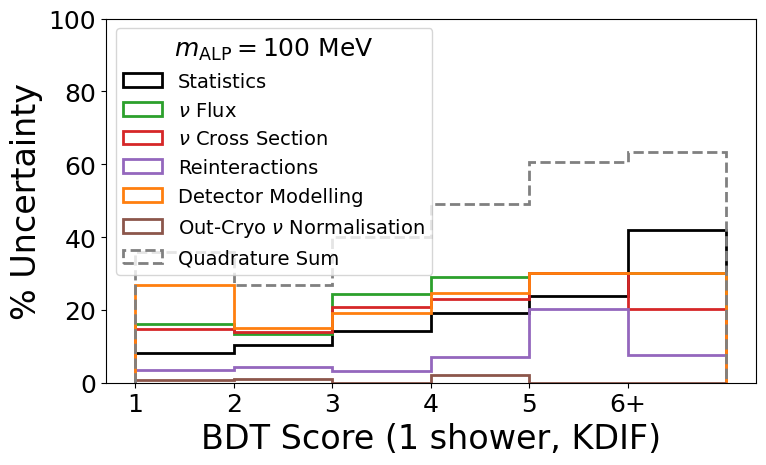

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


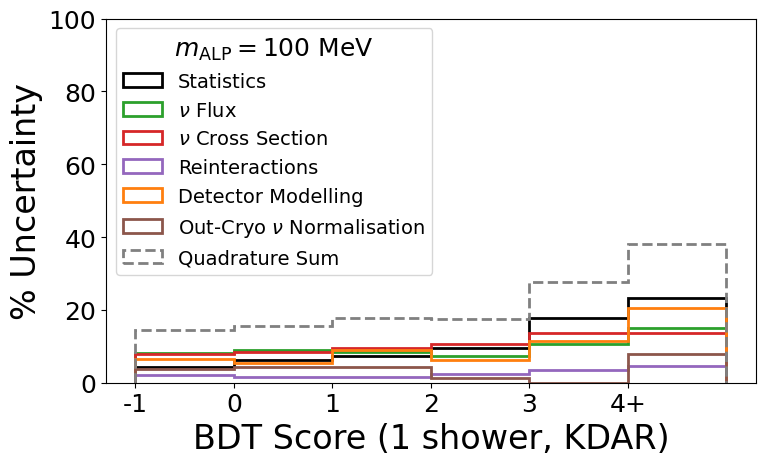

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


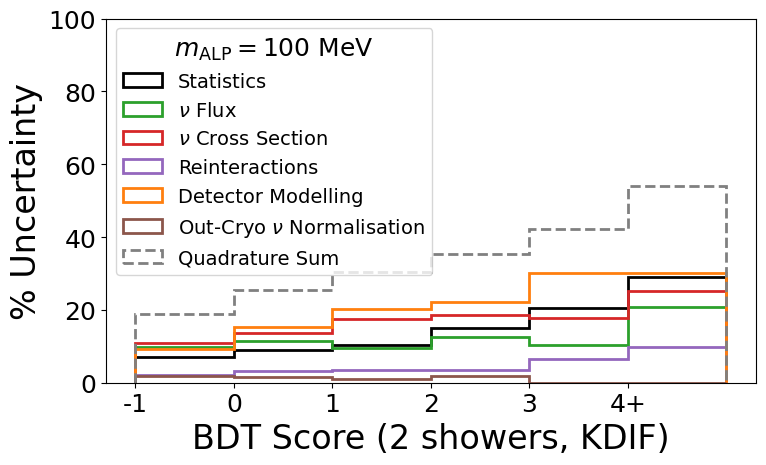

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


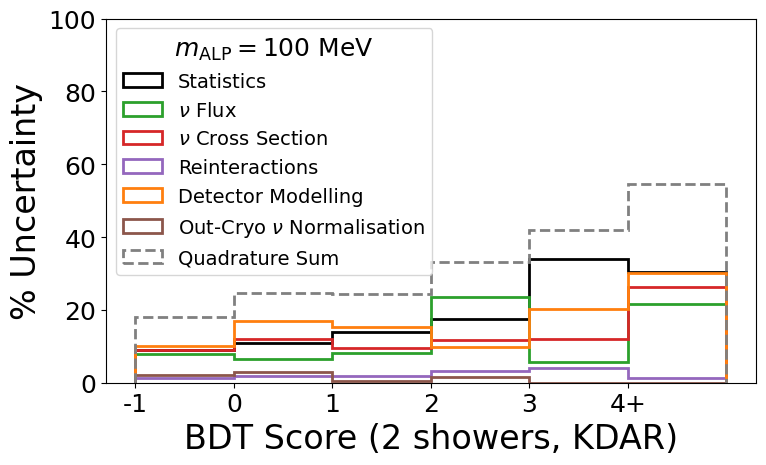

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


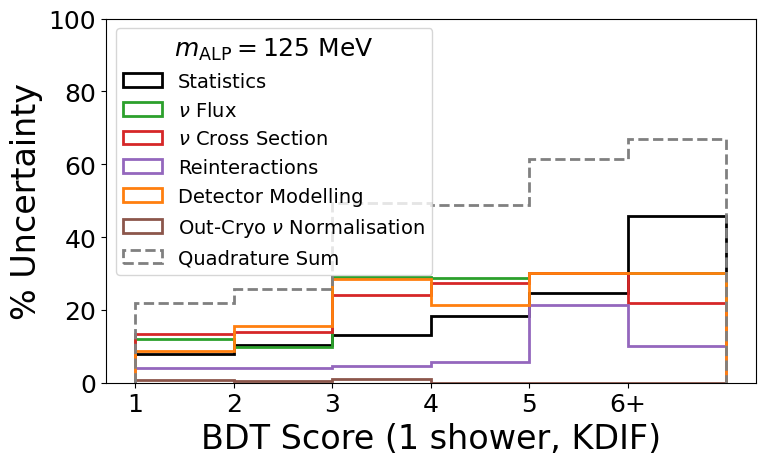

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


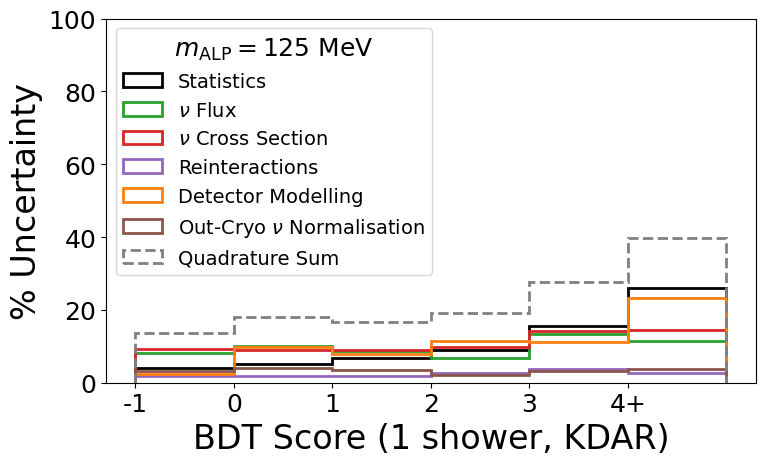

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


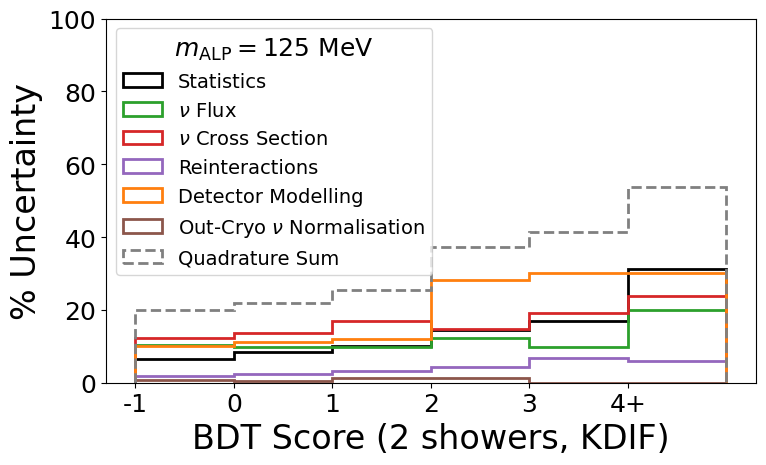

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


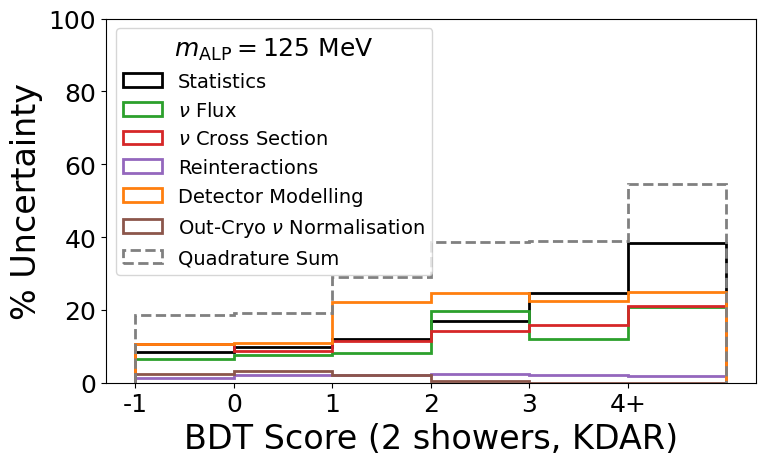

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


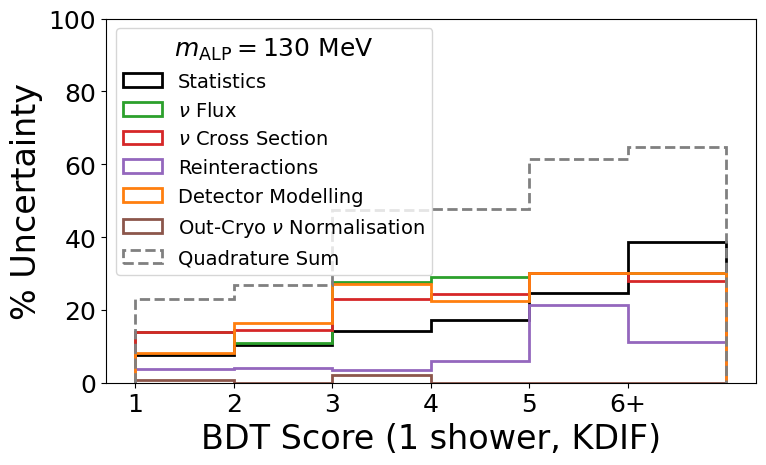

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


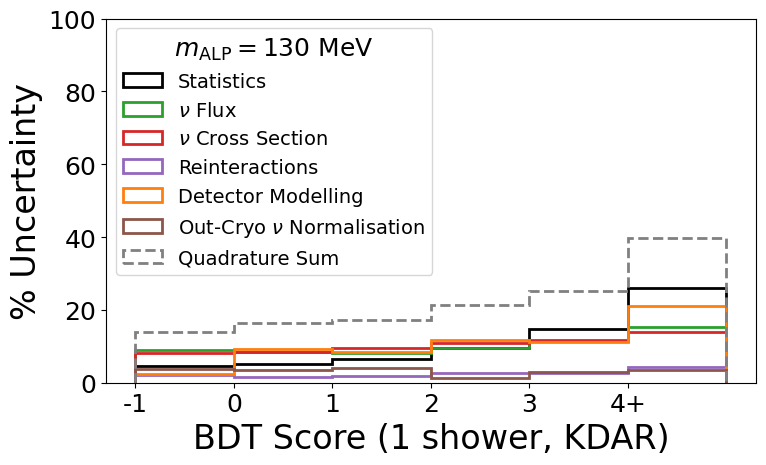

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


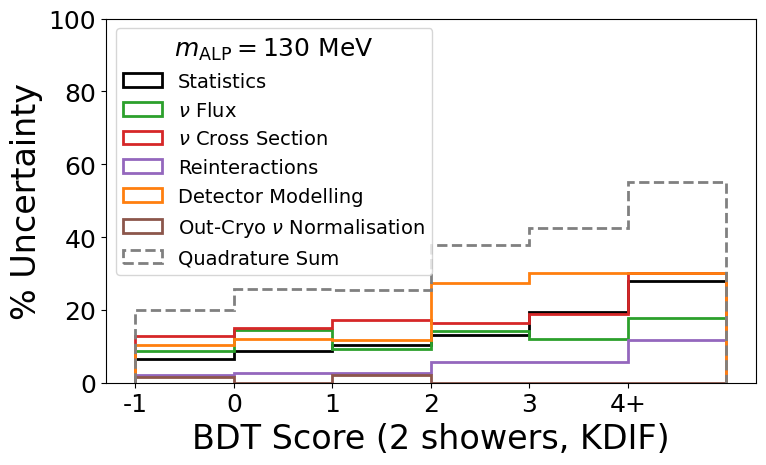

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


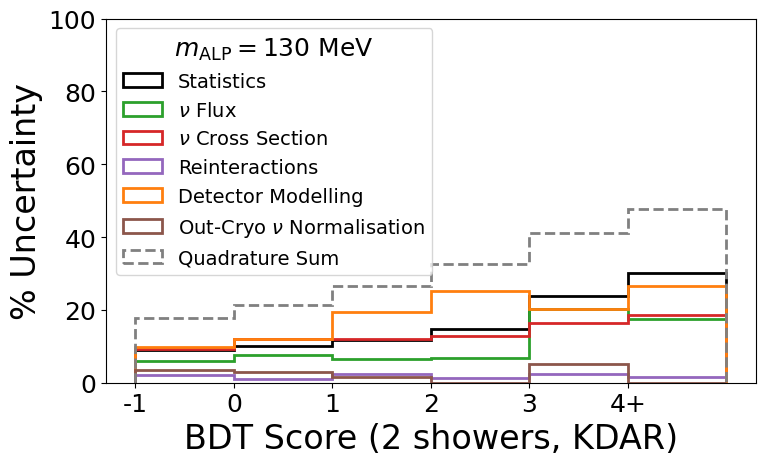

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


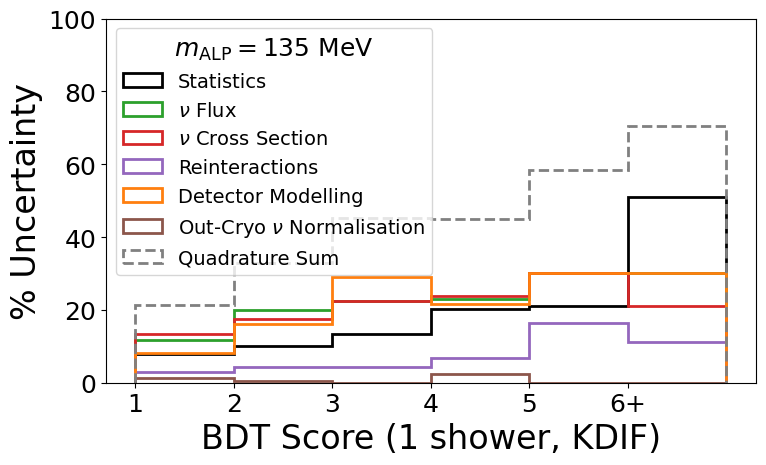

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


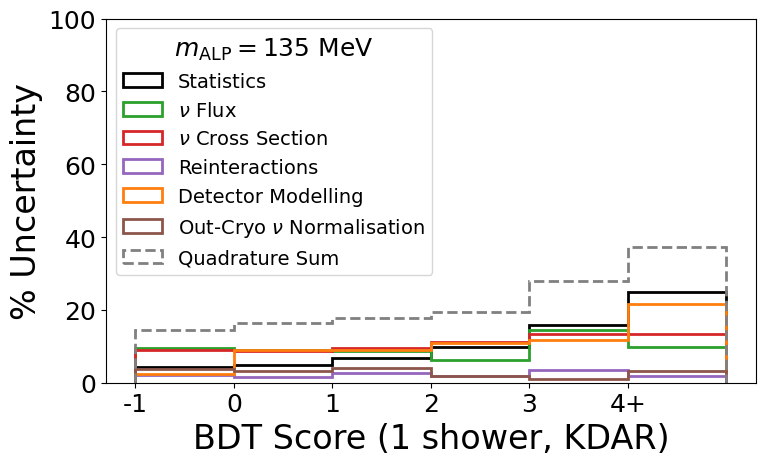

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


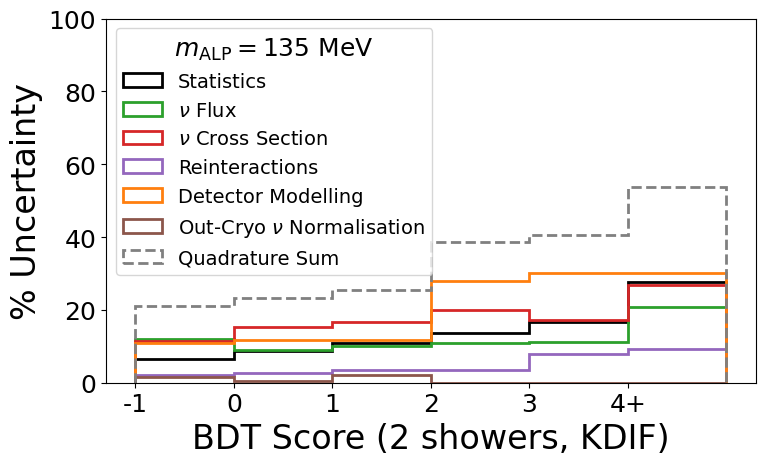

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


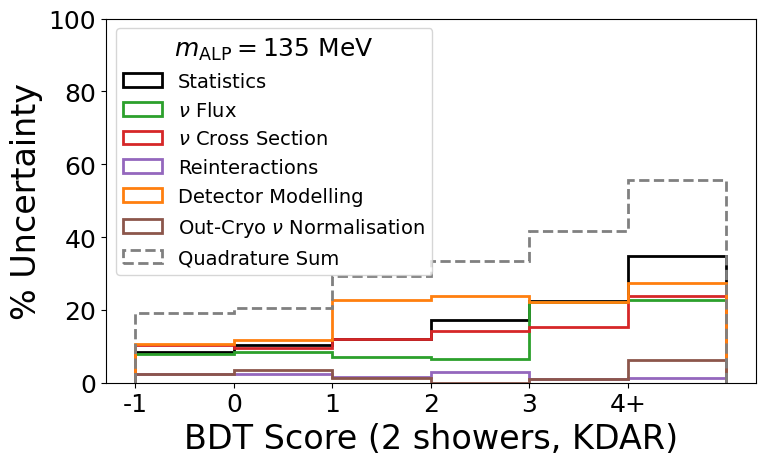

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


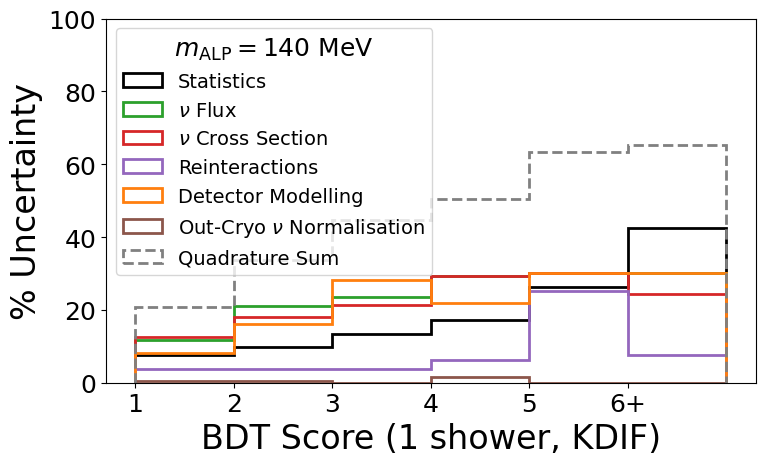

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


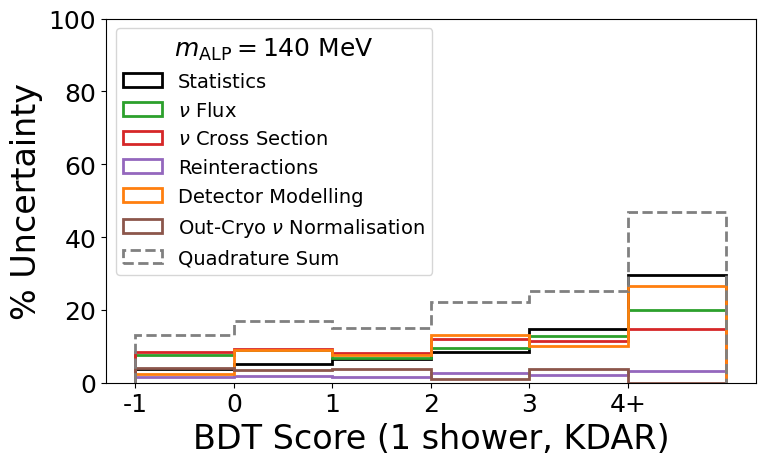

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


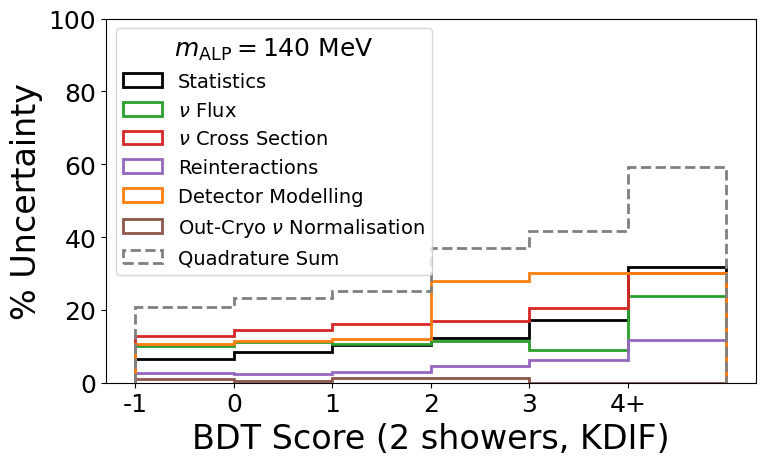

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


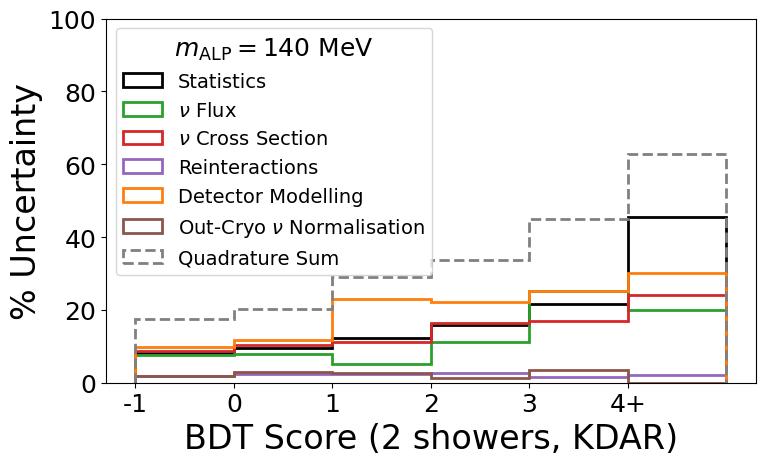

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


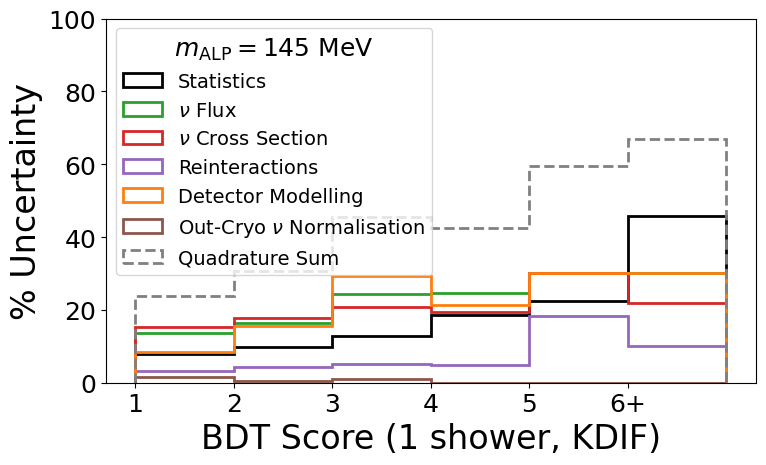

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


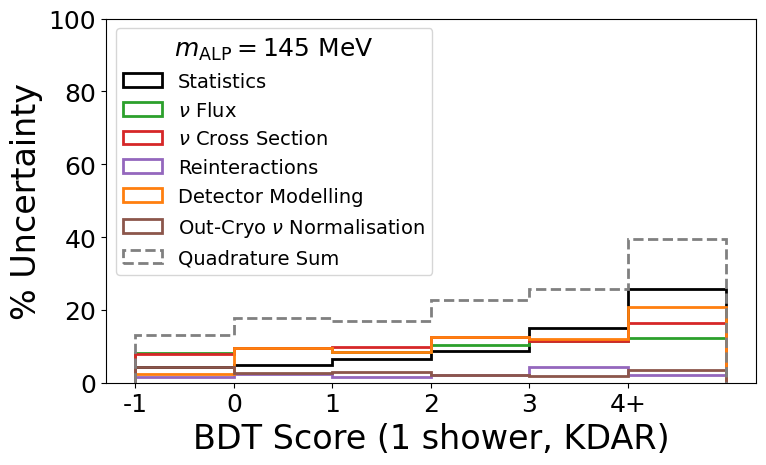

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


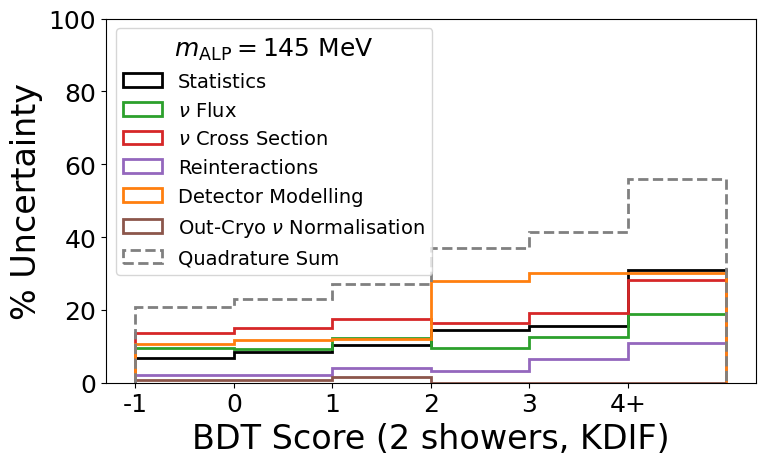

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


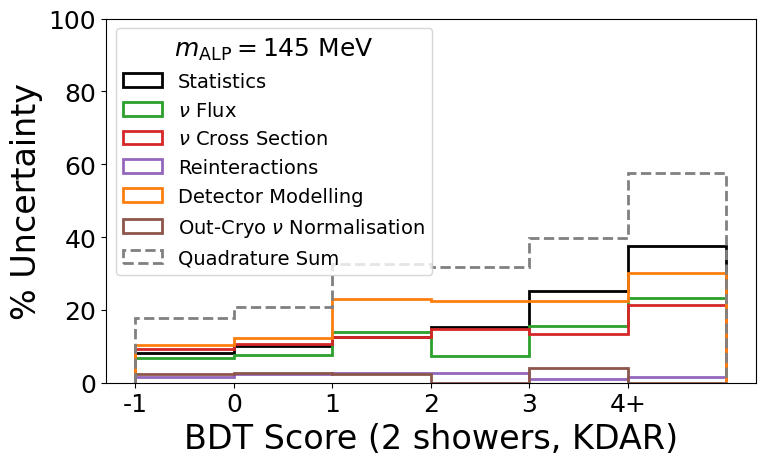

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


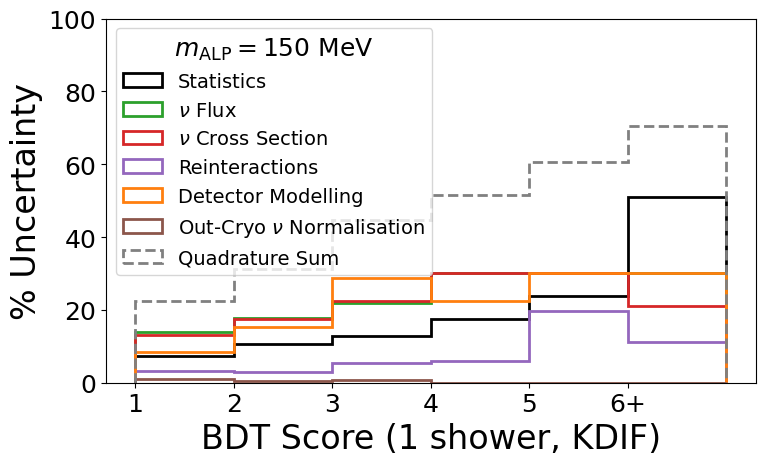

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


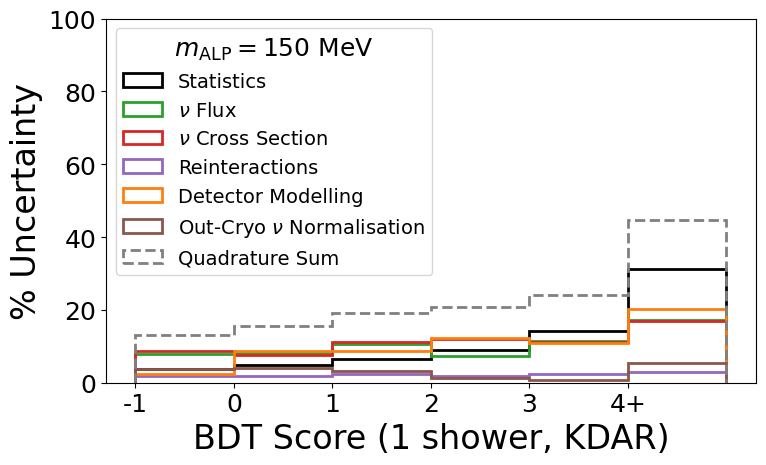

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


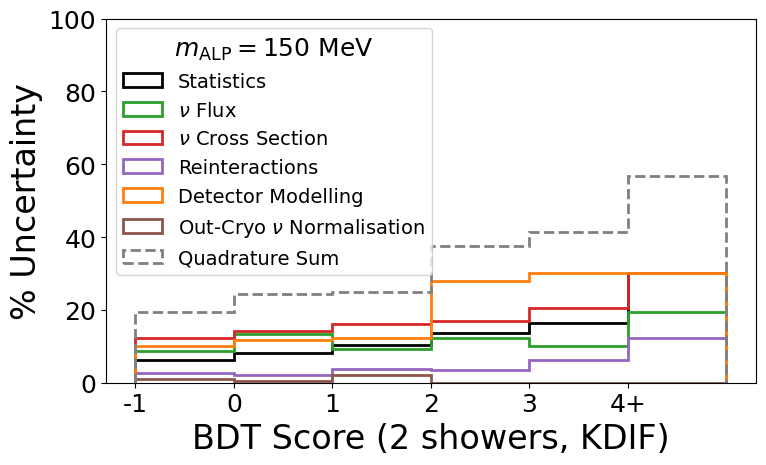

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


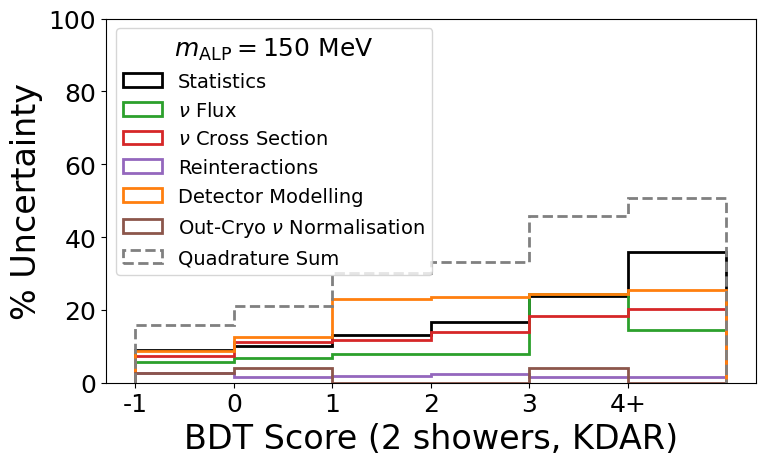

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


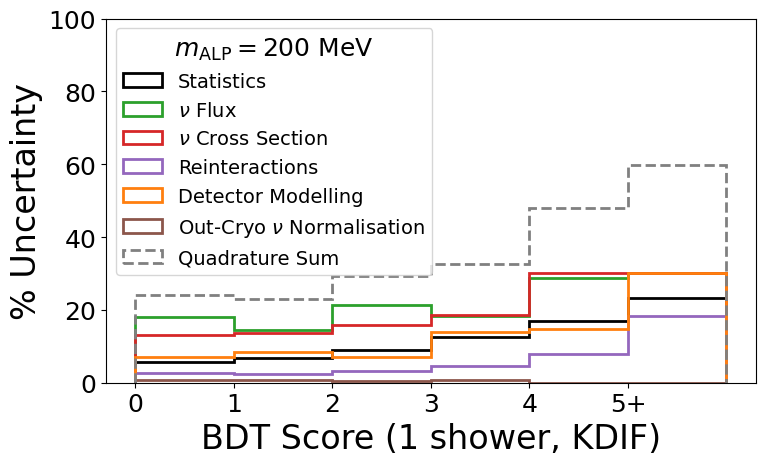

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


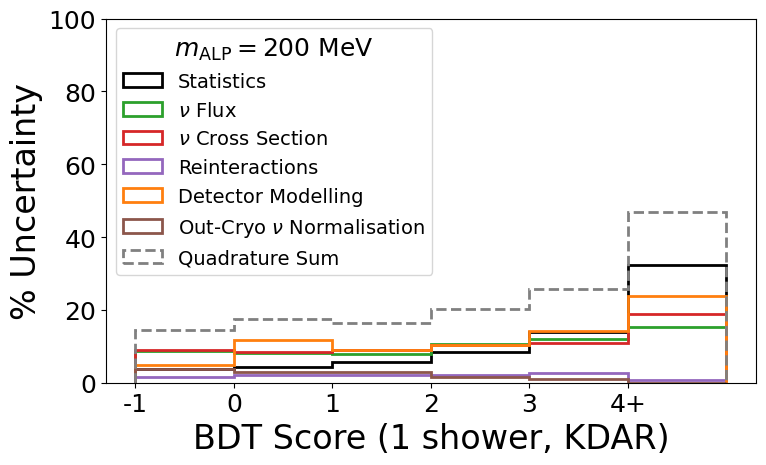

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


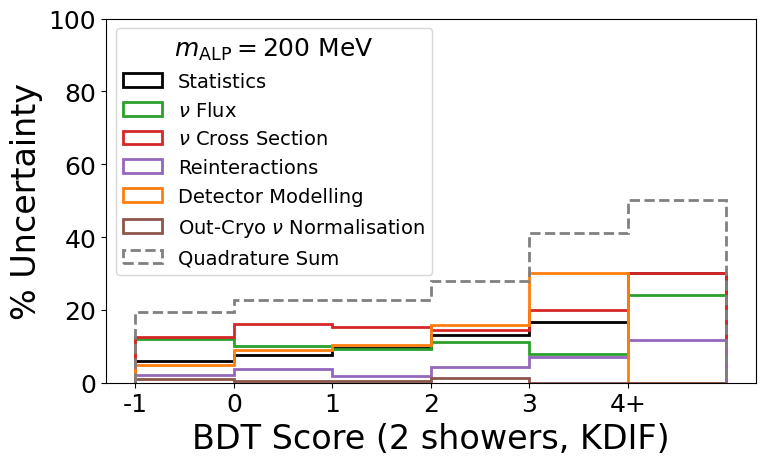

Statistics
$\nu$ Flux
$\nu$ Cross Section
Reinteractions
Detector Modelling
Out-Cryo $\nu$ Normalisation


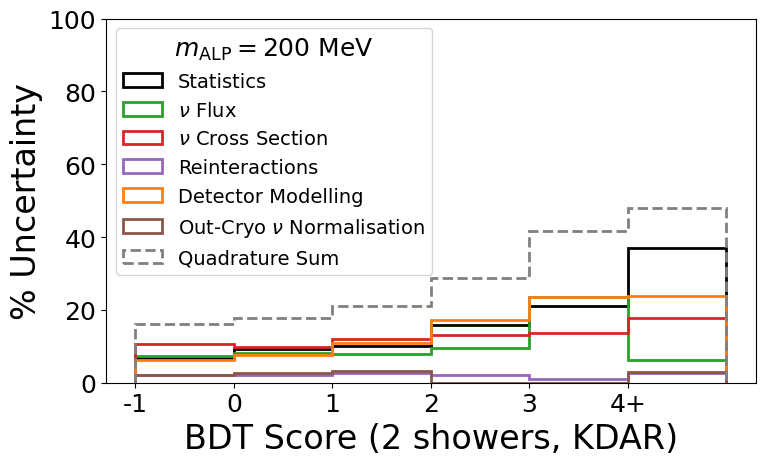

In [25]:

Run = "run3"

if Run == "run1": 
    hist_dict, bins_overflow, bins_cents = hist_dict_run1, bins_overflow_r1, bins_cents_overflow_r1
    bkg_stat_to_use, sig_stat_to_use = bkg_stat_r1_hists, sig_stat_r1_hists
    xticks_dict, vals_dict = xticks_dict_r1, vals_dict_r1
if Run == "run3": 
    hist_dict, bins_overflow, bins_cents = hist_dict_run3, bins_overflow_r3, bins_cents_overflow_r3
    bkg_stat_to_use, sig_stat_to_use = bkg_stat_r3_hists, sig_stat_r3_hists
    xticks_dict, vals_dict = xticks_dict_r3, vals_dict_r3

if Params_pyhf["Scale_flux_uncertainty"] != 1:
    print("Flux uncertainty scaled by {}".format(Params_pyhf["Scale_flux_uncertainty"]))

plot_bkg_total_unc_contributions(hist_dict, bkg_stat_to_use, bins_overflow, bins_cents, xticks_dict, vals_dict,
                                    Params_pyhf, Unc_colors, Run=Run, name_type="", plot_total=True)

## Scaling signal

In [26]:
def scale_signal(Total_dict, theta_dict, scaling_dict={}):
    """
    Scales the number of events by the number in the scaling dict.
    Returns the new dict of histograms and the new thetas.
    """
    if(scaling_dict=={}): raise Exception("Specify scalings")
    Total_dict_scaled, new_theta_dict = copy.deepcopy(Total_dict), {}
    
    for HNL_mass in Total_dict.keys():
        HNL_mass_label = int(HNL_mass.split("_")[0])
        new_signal_hist = np.array(Total_dict[HNL_mass]['TOT_SIGNAL_VALS'])*scaling_dict[HNL_mass_label]
        new_signal_err_hist = np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR'])*scaling_dict[HNL_mass_label]
        new_signal_stat_err = np.array(Total_dict[HNL_mass]['SIGNAL_STAT'])*scaling_dict[HNL_mass_label]
        new_signal_shapesys = np.array(Total_dict[HNL_mass]['SIGNAL_SHAPESYS'])*scaling_dict[HNL_mass_label]
        new_signal_detvar = np.array(Total_dict[HNL_mass]['SIGNAL_DETVAR'])*scaling_dict[HNL_mass_label]
        new_theta = theta_dict[HNL_mass_label]*scaling_dict[HNL_mass_label]**(1/4) # Number of events is proportional to theta**4
        
        Total_dict_scaled[HNL_mass]['TOT_SIGNAL_VALS'] = list(new_signal_hist)
        Total_dict_scaled[HNL_mass]['TOT_SIGNAL_ERR'] = list(new_signal_err_hist)
        Total_dict_scaled[HNL_mass]['SIGNAL_STAT'] = list(new_signal_stat_err)
        Total_dict_scaled[HNL_mass]['SIGNAL_SHAPESYS'] = list(new_signal_shapesys)
        Total_dict_scaled[HNL_mass]['SIGNAL_DETVAR'] = list(new_signal_detvar)
        
        new_theta_dict[HNL_mass] = new_theta
        
    return Total_dict_scaled, new_theta_dict

def scale_signal_merged(Total_dict, theta_dict, scaling_dict={}):
    """
    Scales the number of events by the number in the scaling dict.
    Returns the new dict of histograms and the new thetas.
    """
    if(scaling_dict=={}): raise Exception("Specify scalings")
    Total_dict_scaled, new_theta_dict = copy.deepcopy(Total_dict), {}
    
    for HNL_mass in Total_dict.keys():
        # HNL_mass_label = int(HNL_mass.split("_")[0])
        new_signal_hist = np.array(Total_dict[HNL_mass]['TOT_SIGNAL_VALS'])*scaling_dict[HNL_mass]
        new_signal_err_hist = np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR'])*scaling_dict[HNL_mass]
        new_signal_stat_err = np.array(Total_dict[HNL_mass]['SIGNAL_STAT'])*scaling_dict[HNL_mass]
        new_signal_shapesys = np.array(Total_dict[HNL_mass]['SIGNAL_SHAPESYS'])*scaling_dict[HNL_mass]
        new_signal_detvar = np.array(Total_dict[HNL_mass]['SIGNAL_DETVAR'])*scaling_dict[HNL_mass]
        new_theta = theta_dict[HNL_mass]*scaling_dict[HNL_mass]**(1/4) # Number of events is proportional to theta**4
        
        Total_dict_scaled[HNL_mass]['TOT_SIGNAL_VALS'] = list(new_signal_hist)
        Total_dict_scaled[HNL_mass]['TOT_SIGNAL_ERR'] = list(new_signal_err_hist)
        Total_dict_scaled[HNL_mass]['SIGNAL_STAT'] = list(new_signal_stat_err)
        Total_dict_scaled[HNL_mass]['SIGNAL_SHAPESYS'] = list(new_signal_shapesys)
        Total_dict_scaled[HNL_mass]['SIGNAL_DETVAR'] = list(new_signal_detvar)
        
        new_theta_dict[HNL_mass] = new_theta
        
    return Total_dict_scaled, new_theta_dict


In [27]:
scaling_dict = {100:1.0,125: 1.0, 130: 1.0, 135: 1.0, 140: 1.0, 145: 1.0,150:1.0,200:1.0} #Scaling for both r1 and r3 combined
scaling_dict_r1 = {100:1.0,125: 1.0, 130: 1.0, 135: 1.0, 140: 1.0, 145: 1.0,150:1.0,200:1.0}
scaling_dict_r3 = {100:1.0,125: 1.0, 130: 1.0, 135: 1.0, 140: 1.0, 145: 1.0,150:1.0,200:1.0}


Total_dict, theta_dict_scaled  = scale_signal_merged(ordered_dict, theta_dict, scaling_dict)
Total_dict_run1_scaled, theta_dict_scaled_r1  = scale_signal_merged(ordered_dict_run1, theta_dict, scaling_dict_r1)
Total_dict_run3_scaled, theta_dict_scaled_r3  = scale_signal_merged(ordered_dict_run3, theta_dict, scaling_dict_r3)
Total_dict_kdif_scaled, theta_dict_scaled_kdif  = scale_signal_merged(ordered_dict_kdif, theta_dict, scaling_dict)
Total_dict_kdar_scaled, theta_dict_scaled_kdar  = scale_signal_merged(ordered_dict_kdar, theta_dict, scaling_dict)
Total_dict_1shr_scaled, theta_dict_scaled_1shr  = scale_signal_merged(ordered_dict_1shr, theta_dict, scaling_dict)
Total_dict_2shr_scaled, theta_dict_scaled_2shr  = scale_signal_merged(ordered_dict_2shr, theta_dict, scaling_dict)
Total_dict_kdar_run1_scaled, theta_dict_scaled_kdar_run1  = scale_signal_merged(ordered_dict_kdar_run1, theta_dict, scaling_dict)

# scaled = True

## Plotting example total hist after scaling

In [28]:
print(theta_dict_scaled)

{100: 0.0005360000068321824, 125: 0.0005499999970197678, 130: 0.0005540000274777412, 135: 0.0005579999997280538, 140: 0.0005629999795928597, 145: 0.0005680000176653266, 150: 0.0005729999975301325, 200: 0.0006580000044777989}


In [29]:
print(Total_dict.keys())

dict_keys([100, 125, 130, 135, 140, 145, 150, 200])


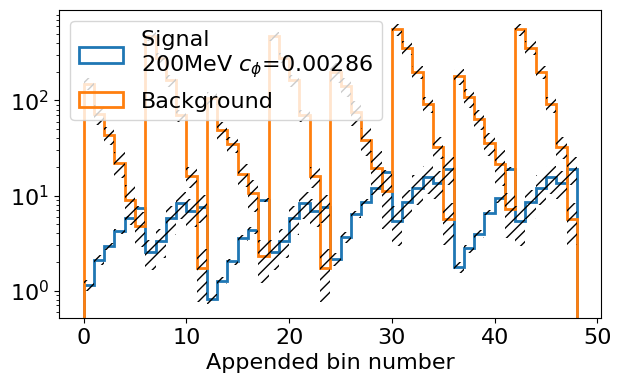

In [30]:
HNL_mass = 200

if REWEIGHTING == True:
    theta = c_phi_dict[HNL_mass]
else:
    theta = theta_dict_scaled[HNL_mass]

plt.rcParams['font.size'] = 16
plt.figure(figsize=(7,4),facecolor='white',dpi=100)

num_bins = len(Total_dict[HNL_mass]['TOT_BKG_VALS'])

bins = np.arange(0,num_bins+1,1)
bins_cents=(bins[:-1]+bins[1:])/2
if REWEIGHTING:    
    plt.hist(bins_cents, weights=Total_dict[HNL_mass]['TOT_SIGNAL_VALS'], bins=bins, histtype="step", lw=2, label=f"Signal \n" + fr"{HNL_mass}MeV $c_\phi$={theta:.5f}")
else:
    plt.hist(bins_cents, weights=Total_dict[HNL_mass]['TOT_SIGNAL_VALS'], bins=bins, histtype="step", lw=2, label=f"Signal \n" + fr"{HNL_mass}MeV $\theta$={theta:.5f}")



plt.hist(bins_cents, weights=Total_dict[HNL_mass]['TOT_BKG_VALS'], bins=bins, histtype="step",lw=2, label="Background")

bkg_up=np.append((Total_dict[HNL_mass]['TOT_BKG_VALS']+np.array(Total_dict[HNL_mass]['TOT_BKG_ERR'])),(Total_dict[HNL_mass]['TOT_BKG_VALS']+np.array(Total_dict[HNL_mass]['TOT_BKG_ERR']))[-1])
bkg_down=np.append((Total_dict[HNL_mass]['TOT_BKG_VALS']-np.array(Total_dict[HNL_mass]['TOT_BKG_ERR'])),(Total_dict[HNL_mass]['TOT_BKG_VALS']-np.array(Total_dict[HNL_mass]['TOT_BKG_ERR']))[-1])
sig_up=np.append((Total_dict[HNL_mass]['TOT_SIGNAL_VALS']+np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR'])),(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']+np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR']))[-1])
sig_down=np.append((Total_dict[HNL_mass]['TOT_SIGNAL_VALS']-np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR'])),(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']-np.array(Total_dict[HNL_mass]['TOT_SIGNAL_ERR']))[-1])

plt.fill_between(bins, bkg_down, bkg_up,step="post",hatch='///',alpha=0,zorder=2)
plt.fill_between(bins, sig_down, sig_up,step="post",hatch='///',alpha=0,zorder=2)

plt.yscale("log")
plt.legend()
plt.xlabel("Appended bin number")
plt.show()


In [36]:
np.sum(Total_dict[HNL_mass]['TOT_SIGNAL_VALS'])

355.9225794672966

### Recreating the BDT score histograms

to verify that the scaling is behaving as expected.

Total_dict keys are:

'TOT_BKG_VALS', 'TOT_SIGNAL_VALS', 'OVERLAY_VALS', 'DIRT_VALS', 'BEAMOFF_VALS', 
'OVERLAY_STAT', 'DIRT_STAT', 'BEAMOFF_STAT', 'TOT_BKG_ERR', 'TOT_SIGNAL_ERR', 
'BKG_STAT', 'BKG_SHAPESYS', 'BKG_DETVAR', 'BKG_DIRT', 'BKG_MULTISIM', 
'BKG_DETVAR_MULTISIM', 'SIGNAL_STAT', 'SIGNAL_SHAPESYS', 'SIGNAL_DETVAR', 
'data', 'BKG_DIRT_R1', 'BKG_DIRT_R3'

Theta used: 0.000536


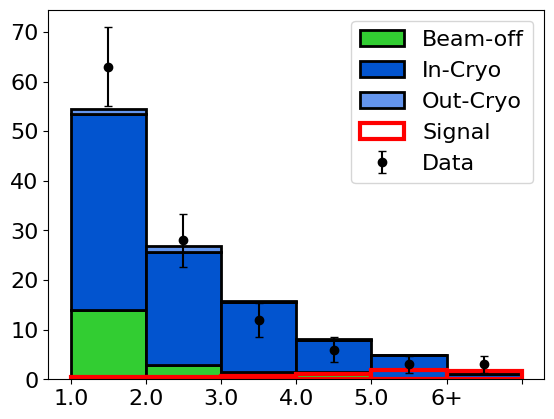

In [37]:
HNL_mass = 100

print(fr'Theta used: {theta_dict_scaled[HNL_mass]:.3}')

using_KDIF = True

index_1 = 0
index_2 = 6
signal = Total_dict[HNL_mass]['TOT_SIGNAL_VALS'][index_1:index_2]
in_cryo = Total_dict[HNL_mass]['OVERLAY_VALS'][index_1:index_2]
out_cryo = Total_dict[HNL_mass]['DIRT_VALS'][index_1:index_2]
beamoff = Total_dict[HNL_mass]['BEAMOFF_VALS'][index_1:index_2]
data = Total_dict[HNL_mass]['data'][index_1:index_2]

bin_edges = np.linspace(0, index_2-index_1, index_2-index_1+1)
bin_cents = np.linspace(0.5,5.5, 6)

plt.bar(bin_cents,beamoff, color='limegreen',lw=2,  edgecolor='black', width=1, label='Beam-off')
plt.bar(bin_cents,in_cryo,  bottom=beamoff, color='#0254cf',lw=2,  edgecolor='black', width=1, label='In-Cryo')
plt.bar(bin_cents,out_cryo, bottom=np.add(in_cryo, beamoff), color='cornflowerblue',lw=2,  edgecolor='black', width=1, label='Out-Cryo')

plt.bar(bin_cents,signal, color='None', edgecolor='red', width=1, lw=3, label='Signal')
plt.errorbar(bin_cents, data, yerr=np.sqrt(data), fmt='o', capsize=3, color='black', label='Data')


plt.legend()

if using_KDIF:
    xticks = np.linspace(1,5,5)
    xticks_labels = np.append(xticks, '6+')
    xticks_labels = np.append(xticks_labels, '')

else:
    xticks = np.linspace(-1,3,5)
    xticks_labels = np.append(xticks, '4+')
    xticks_labels = np.append(xticks_labels, '')

xticks = np.linspace(0,6,7)

plt.xticks(xticks, labels=xticks_labels)
# plt.yscale("log")
plt.show()

## Creating model (only do once happy with scaling)

In [38]:
def create_model_dict_separated(Total_dict, debug=False):
    """
    Creating a model where the background samples are fed in individually (takes longer than summing into one total bkg hist).
    """
    model_dict = {}
    sig_norm = {"hi": 1.0+Params_pyhf["Signal_flux_error"], "lo": 1.0-Params_pyhf["Signal_flux_error"]}
    dirt_norm = {"hi": 1.0+Params_pyhf["Flat_bkg_dirt_frac"], "lo": 1.0-Params_pyhf["Flat_bkg_dirt_frac"]}
    for HNL_mass in Total_dict:
        if(debug):print(HNL_mass)
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[HNL_mass]['TOT_SIGNAL_VALS'],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be scanned over in the hypo tests
                {"name": "stat_siguncrt", "type": "staterror", "data": sig_stat[HNL_mass]},
                {"name": "norm_siguncrt", "type": "normsys", "data": sig_norm}, #NuMI absorber KDAR rate
                {"name": "Detvar_sig", "type": "shapesys", "data": Total_dict[HNL_mass]['SIGNAL_DETVAR']} #shapesys assumes uncorrelated
              ]
            },
            {
              "name": "overlay",
              "data": Total_dict[HNL_mass]['OVERLAY_VALS'],
              "modifiers": [
                {"name": "stat_overlay", "type": "staterror", "data": overlay_stat[HNL_mass]},
                {"name": "Multisim_overlay", "type": "shapesys", "data": Total_dict[HNL_mass]['BKG_MULTISIM']},
                {"name": "Detvar_overlay", "type": "shapesys", "data": Total_dict[HNL_mass]['BKG_DETVAR']} #shapesys assumes uncorrelated
              ]
            },
            {
              "name": "dirt",
              "data": Total_dict[HNL_mass]['DIRT_VALS'],
              "modifiers": [
                {"name": "stat_dirt", "type": "staterror", "data": dirt_stat[HNL_mass]},
                {"name": "dirt_norm", "type": "normsys", "data": dirt_norm}
              ]
            },
            {
              "name": "beamoff",
              "data": Total_dict[HNL_mass]['BEAMOFF_VALS'],
              "modifiers": [
                {"name": "stat_beamoff", "type": "staterror", "data": beamoff_stat[HNL_mass]}
              ]
            }
          ]
        }
      ]
    }
    )
    return model_dict

def create_model_dict_same(Total_dict, debug=False):
    """
    Creating a model where the uncertainties are all enveloped in one shapesys modifier for signal and bkg.
    The total errors are taken from \"TOT_SIGNAL_ERR\" and \"TOT_BKG_ERR\" respectively.
    """
    model_dict = {}
    
    for HNL_mass in Total_dict:
        if(debug):print(HNL_mass)
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[HNL_mass]['TOT_SIGNAL_VALS'],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None, }, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]["TOT_SIGNAL_ERR"]}
              ]
            },
            {
              "name": "background",
              "data": Total_dict[HNL_mass]['TOT_BKG_VALS'],
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]["TOT_BKG_ERR"]}
              ]
            }
          ]
        }
      ],
      "parameters": [
            {
                "name": "mu",
                "bounds": [[0, 1000000]],
            }
      ],

    }
    )
    return model_dict


def create_model_dict_stat(Total_dict, debug=False):
    """
    Creating a model where the uncertainties are all enveloped in one shapesys modifier for signal and bkg.
    The total errors are taken from \"TOT_SIGNAL_ERR\" and \"TOT_BKG_ERR\" respectively.
    """
    model_dict = {}
    
    for HNL_mass in Total_dict:
        if(debug):print(HNL_mass)
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[HNL_mass]['TOT_SIGNAL_VALS'],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None, }, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]["SIGNAL_STAT"]}
              ]
            },
            {
              "name": "background",
              "data": Total_dict[HNL_mass]['TOT_BKG_VALS'],
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict[HNL_mass]["BKG_STAT"]}
              ]
            }
          ]
        }
      ],
      "parameters": [
            {
                "name": "mu",
                "bounds": [[0, 1000000]],
            }
      ],

    }
    )
    return model_dict

In [39]:
# if scaled==False:
#     print("Using unscaled hists")
#     Total_dict, theta_dict_scaled = Total_dict_both, theta_dict

model_dict_both = create_model_dict_same(Total_dict)
# model_dict_both = create_model_dict_separated(Total_dict) #All individual samples, all individual errors

# model_dict_split = create_model_dict_split(Total_dict_both)

# model_dict_both = create_model_correlated(Total_dict)
# model_dict_corr = create_model_correlated(Total_dict) 
# model_dict_uncorr = create_model_uncorrelated(Total_dict) 

model_dict_run1 = create_model_dict_same(Total_dict_run1_scaled)
model_dict_run3 = create_model_dict_same(Total_dict_run3_scaled)

model_dict_kdif = create_model_dict_same(Total_dict_kdif_scaled)
model_dict_kdar = create_model_dict_same(Total_dict_kdar_scaled)

model_dict_1shr = create_model_dict_same(Total_dict_1shr_scaled)
model_dict_2shr = create_model_dict_same(Total_dict_2shr_scaled)

model_dict_kdar_run1 = create_model_dict_same(Total_dict_kdar_run1_scaled)

create_model_dict_separated = create_model_dict_separated(Total_dict)
model_dict_stat = create_model_dict_stat(Total_dict)

print("Created models \n")

HNL_mass = 100

print(f'Samples:\n {model_dict_both[HNL_mass].config.samples}')
print(f'Modifiers are:\n {model_dict_both[HNL_mass].config.modifiers}')

Created models 

Samples:
 ['background', 'signal']
Modifiers are:
 [('mu', 'normfactor'), ('uncorr_bkguncrt', 'shapesys'), ('uncorr_siguncrt', 'shapesys')]


## Running through all points

In [40]:
run = 'all' # 'all', 'run1', 'run3' , 'kdif', 'kdar', '1shr', '2shr' 'separated'

if run == 'all':
    model_dict = model_dict_both #Quicker, uncertainties are entered as one uncertainty which is the quadsum of components.
elif run == 'run1':
    model_dict = model_dict_run1
elif run == 'run3':
    model_dict = model_dict_run3
elif run == 'kdif':
    model_dict = model_dict_kdif
elif run == 'kdar':
    model_dict = model_dict_kdar
elif run == '1shr':
    model_dict = model_dict_1shr
elif run == '2shr':
    model_dict = model_dict_2shr
elif run == 'stat':
    model_dict = model_dict_stat
elif run == 'kdar_run1':
    model_dict = model_dict_kdar_run1
# elif run == 'separated':
#     model_dict = create_model_dict_separated(Total_dict)

DATA_OBS_dict = {}

for HNL_mass in model_dict:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only
    list_keys = list(Total_dict[HNL_mass].keys())

    if run == 'all' or run == 'stat' or run == 'separated':
        list_keys = list(Total_dict[HNL_mass].keys())
        if "data" in list_keys: #haven't made this yet, need to test
            DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
        else:
            DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]['TOT_BKG_VALS']+model_dict[HNL_mass].config.auxdata
            
    elif run == 'run1':
        list_keys = list(Total_dict_run1[HNL_mass].keys())
        if 'data' in list_keys:
            DATA_OBS_dict[HNL_mass] = Total_dict_run1[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
        else:
            DATA_OBS_dict[HNL_mass] = Total_dict_run1[HNL_mass]['TOT_BKG_VALS']+model_dict[HNL_mass].config.auxdata
    elif run == 'run3':
        list_keys = list(Total_dict_run3[HNL_mass].keys())
        if 'data' in list_keys:
            DATA_OBS_dict[HNL_mass] = Total_dict_run3[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
        else: 
            DATA_OBS_dict[HNL_mass] = Total_dict_run3[HNL_mass]['TOT_BKG_VALS']+model_dict[HNL_mass].config.auxdata
    elif run == 'kdif':
        list_keys = list(Total_dict_run3[HNL_mass].keys())
        if 'data' in list_keys:
            DATA_OBS_dict[HNL_mass] = Total_dict_kdif[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
        else: 
            DATA_OBS_dict[HNL_mass] = Total_dict_kdif[HNL_mass]['TOT_BKG_VALS']+model_dict[HNL_mass].config.auxdata
    elif run == 'kdar':
        list_keys = list(Total_dict_run3[HNL_mass].keys())
        if 'data' in list_keys:
            DATA_OBS_dict[HNL_mass] = Total_dict_kdar[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
        else: 
            DATA_OBS_dict[HNL_mass] = Total_dict_kdar[HNL_mass]['TOT_BKG_VALS']+model_dict[HNL_mass].config.auxdata
    elif run == '1shr':
        list_keys = list(Total_dict_run3[HNL_mass].keys())
        if 'data' in list_keys:
            DATA_OBS_dict[HNL_mass] = Total_dict_1shr[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
        else: 
            DATA_OBS_dict[HNL_mass] = Total_dict_1shr[HNL_mass]['TOT_BKG_VALS']+model_dict[HNL_mass].config.auxdata
    elif run == '2shr':
        list_keys = list(Total_dict_run3[HNL_mass].keys())
        if 'data' in list_keys:
            DATA_OBS_dict[HNL_mass] = Total_dict_2shr[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
        else:
            DATA_OBS_dict[HNL_mass] = Total_dict_2shr[HNL_mass]['TOT_BKG_VALS']+model_dict[HNL_mass].config.auxdata
    elif run == 'kdar_run1':
        list_keys = list(Total_dict_run3[HNL_mass].keys())
        if 'data' in list_keys:
            DATA_OBS_dict[HNL_mass] = Total_dict_kdar_run1[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
        else:
            DATA_OBS_dict[HNL_mass] = Total_dict_kdar_run1[HNL_mass]['TOT_BKG_VALS']+model_dict[HNL_mass].config.auxdata
    else: print('Error creating DATA_OBS_dict')
    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])



In [41]:
#Should take ~10 mins for each with 5 bins, 100 mu values
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of an upper limit calculation is equal to the lowest or highest value of poi, the range needs to be extended")

# poi_values = np.linspace(1000, 10000,10) #Values of mu which are scanned over in hypo tests. Default: np.linspace(0.001, 2, 100)
# print("Max value is " + str(max(poi_values)))
# print("Min value is " + str(min(poi_values)))
# print("Next value is " + str(poi_values[1]))
# print("Next value is " + str(poi_values[2]) + "\n")

print("-----Starting Hypothesis tests-----" + "\n")
print("Run = " + run)
CL_level = 0.05
print(f"CLs CL is {(1-CL_level)*100}%")

if CL_level != 0.05: print("WARNING, the CL should usually be 95%, here it is not.")
print()

num_steps = 100

if REWEIGHTING:
    poi_dict = {
        100:np.linspace(0.001, 2, num_steps),
        125:np.linspace(0.01, 10, num_steps),
        130:np.linspace(0.1, 1000, num_steps),
        135:np.linspace(0.1, 10000, num_steps),
        140:np.linspace(0.1, 10000, num_steps),
        145:np.linspace(0.001, 5, num_steps),
        150:np.linspace(0.001, 2, num_steps),
        200:np.linspace(0.001, 2, num_steps),
    }
else: 
    poi_dict = {
        100:np.linspace(0.001, 2, num_steps),
        125:np.linspace(0.001, 2, num_steps),
        130:np.linspace(0.001, 2, num_steps),
        135:np.linspace(0.001, 2, num_steps),
        140:np.linspace(0.001, 2, num_steps),
        145:np.linspace(0.001, 2, num_steps),
        150:np.linspace(0.001, 2, num_steps),
        200:np.linspace(0.001, 2, num_steps),
    }
\
masses = [100, 150,200]
# for HNL_mass in masses:

for HNL_mass in model_dict:
    poi_values = poi_dict[HNL_mass]

    print("Max value is " + str(max(poi_values)))
    print("Min value is " + str(min(poi_values)))
    print("Next value is " + str(poi_values[1]))
    print("Next value is " + str(poi_values[2]) + "\n")

    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=CL_level, return_results=True
    )
    

    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.6f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.6f}" + "\n")

If the output of an upper limit calculation is equal to the lowest or highest value of poi, the range needs to be extended
-----Starting Hypothesis tests-----

Run = all
CLs CL is 95.0%

Max value is 2.0
Min value is 0.001
Next value is 0.021191919191919192
Next value is 0.041383838383838384

Upper limit 100MeV (obs): μ = 0.732993
Upper limit 100MeV (exp): μ = 0.634219

Max value is 10.0
Min value is 0.01
Next value is 0.1109090909090909
Next value is 0.21181818181818182

Upper limit 125MeV (obs): μ = 2.689542
Upper limit 125MeV (exp): μ = 2.394885

Max value is 1000.0
Min value is 0.1
Next value is 10.2
Next value is 20.3



/Users/user/miniconda3/envs/HPS/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Upper limit 130MeV (obs): μ = 20.939944
Upper limit 130MeV (exp): μ = 25.253180

Max value is 10000.0
Min value is 0.1
Next value is 101.1090909090909
Next value is 202.1181818181818



/Users/user/miniconda3/envs/HPS/lib/python3.11/site-packages/pyhf/infer/calculators.py:418: RuntimeWarning: divide by zero encountered in scalar divide
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)
/Users/user/miniconda3/envs/HPS/lib/python3.11/site-packages/pyhf/infer/calculators.py:467: RuntimeWarning: invalid value encountered in divide
  CLs = tensorlib.astensor(CLsb / CLb)


Upper limit 135MeV (obs): μ = 10000.000000
Upper limit 135MeV (exp): μ = 10000.000000

Max value is 10000.0
Min value is 0.1
Next value is 101.1090909090909
Next value is 202.1181818181818

Upper limit 140MeV (obs): μ = 96.024801
Upper limit 140MeV (exp): μ = 96.024572

Max value is 5.0
Min value is 0.001
Next value is 0.05149494949494949
Next value is 0.10198989898989898

Upper limit 145MeV (obs): μ = 3.030657
Upper limit 145MeV (exp): μ = 3.336945

Max value is 2.0
Min value is 0.001
Next value is 0.021191919191919192
Next value is 0.041383838383838384

Upper limit 150MeV (obs): μ = 0.894332
Upper limit 150MeV (exp): μ = 1.168633

Max value is 2.0
Min value is 0.001
Next value is 0.021191919191919192
Next value is 0.041383838383838384

Upper limit 200MeV (obs): μ = 0.251285
Upper limit 200MeV (exp): μ = 0.171678



In [42]:
# obs_limit_dict[HNL_mass]

exp_limit = [] #entry 2
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0
obs_limit = []

for HNL_mass in obs_limit_dict:
    if REWEIGHTING == True:
        theta = c_phi_dict[HNL_mass]
    else:
        theta = theta_dict_scaled[HNL_mass]

    #N events scales with mixing angle squared
    obs_limit.append(theta*np.sqrt(obs_limit_dict[HNL_mass]))
    exp_limit.append(theta*np.sqrt(exp_limits_dict[HNL_mass][2]))

    exp_1sig_up.append(theta*np.sqrt(exp_limits_dict[HNL_mass][3]))
    exp_2sig_up.append(theta*np.sqrt(exp_limits_dict[HNL_mass][4]))
    exp_1sig_down.append(theta*np.sqrt(exp_limits_dict[HNL_mass][1]))
    exp_2sig_down.append(theta*np.sqrt(exp_limits_dict[HNL_mass][0]))

## Saving limits

In [43]:
masses = list(model_dict.keys())

if REWEIGHTING:
    save_loc = "limit_files/RW_Brazil_plot/"
else: 
    save_loc = "limit_files/Brazil_plot/"
to_save_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
to_save_lists = [exp_1sig_up,exp_1sig_down,exp_2sig_up,exp_2sig_down,exp_limit,obs_limit]

if run == 'all':
    filename=f"_ALL_Capped_HPS_rebinned_limit.csv"
elif run == 'stat':
    filename=f"_stat_only_Capped_HPS_rebinned_limit.csv"
elif run == 'run1':
    filename=f"_Run1_Capped_HPS_rebinned_limit.csv"
elif run == 'run3':
    filename=f"_Run3_Capped_HPS_rebinned_limit.csv"
elif run == 'kdif':
    filename=f"_KDIF_Capped_HPS_rebinned_limit.csv"
elif run == 'kdar':
    filename=f"_KDAR_Capped_HPS_rebinned_limit.csv"
elif run == '1shr':
    filename=f"_1shr_Capped_HPS_rebinned_limit.csv"
elif run == '2shr':
    filename=f"_2shr_Capped_HPS_rebinned_limit.csv"
elif run == 'separated':
    filename=f"_separated_Capped_HPS_rebinned_limit.csv"
elif run == 'kdar_run1':
    filename=f"_KDAR_Run1_Capped_HPS_rebinned_limit.csv"

if Params_pyhf["Stats_only"] == True:
    filename="_stats"+filename


elif Params_pyhf["Scale_flux_uncertainty"] != 1:
    filename="_flux_scaled"+filename

if Params_pyhf["Scale_signal_flux"] != 1.:
    ext = "_signal_scaled_{}".format(Params_pyhf["Scale_signal_flux"])
    filename = ext + filename
    if type(Params_pyhf["Scale_signal_flux"]) == float:
        filename = filename.replace(".","_",1)

if Params_pyhf["Scale_kdar_signal_flux"] != 1.:
    ext = "_kdar_signal_scaled_{}".format(Params_pyhf["Scale_kdar_signal_flux"])
    filename = ext + filename
    if type(Params_pyhf["Scale_kdar_signal_flux"]) == float:
        filename = filename.replace(".","_",1)
    

if Params_pyhf["Scale_bkg_neutrino_flux"] != 1.:
    ext = "_flux_scaled_{}".format(Params_pyhf["Scale_bkg_neutrino_flux"])
    filename = ext + filename
    if type(Params_pyhf["Scale_bkg_neutrino_flux"]) == float:
        filename = filename.replace(".","_",1)

for i, lim in enumerate(to_save_lists):

    r = zip(masses, lim)
    savestr=to_save_names[i]
    savename = root_dir+save_loc+savestr+filename
    with open(savename, "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)

print("Last saved is " + savename)

Last saved is /Users/user/PhD/HPS_uboone_analysis/limit_files/RW_Brazil_plot/obs_limit_ALL_Capped_HPS_rebinned_limit.csv


## Plotting Brazil plot

In [3]:
def Get_sigma_bands(filename, root_path = root_dir, RW = False):
    """
    Load sigma bands for each mass point from .csv files saved above.
    Filename is without the decay type or .csv
    """
    to_load_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
    loaded_lists = []
    for i, name in enumerate(to_load_names):
        if RW:
            full_path = root_path+f"limit_files/RW_Brazil_plot/{name}_{filename}.csv"
        else:
            full_path = root_path+f"limit_files/Brazil_plot/{name}_{filename}.csv"
        if(os.path.exists(full_path)):
            with open(full_path, "r") as fp:   # Unpickling
                reader = csv.reader(fp)
                loaded_list = list(reader)
                loaded_lists.append(loaded_list)
                
    return loaded_lists

def Make_dicts_for_limits(loaded_lists):
    """
    Takes output of Get_sigma_bands and translates to dict with HNL masses as keys.
    """
    to_load_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
    lims_dict = {}
    print(loaded_lists)
    for i, exp_lim_list in enumerate(loaded_lists[0]):
        # if isinstance(exp_lim_list[0], str):
        HNL_mass = int(exp_lim_list[0])
        # else: HNL_mass = exp_lim_list[0]
        individual_lims = {}
        for j, lims in enumerate(loaded_lists):
            individual_lims[to_load_names[j]] = float(loaded_lists[j][i][1])
        lims_dict[int(HNL_mass)] = individual_lims
    
    return lims_dict

def Make_list_limits(loaded_lists):
    """
    Takes output of Get_sigma_bands and translates to dict with lists of limit vals.
    """
    to_load_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
    lims_dict = {}
    for i, exp_lim_list in enumerate(loaded_lists):
        lims_list, mass_list = [], []
        for j, val in enumerate(exp_lim_list):
            lims_list.append(float(val[1]))
            mass_list.append(int(val[0]))
        
        lims_dict[to_load_names[i]] = lims_list
    
    return lims_dict, mass_list


[[['100', '0.00037225562634714173'], ['125', '0.00030948770938717807'], ['130', '0.0002950405543584877'], ['135', '0.0002878672969122137'], ['140', '0.00026565560788723263'], ['145', '0.00025974519474784543'], ['150', '0.0002431152883481157'], ['200', '0.00018614065197585604']], [['100', '0.0002641580753349661'], ['125', '0.00022034506608550517'], ['130', '0.0002109769803351668'], ['135', '0.0002057208242169754'], ['140', '0.00018973980482647372'], ['145', '0.0001837729635907518'], ['150', '0.00017314207054762218'], ['200', '0.00013278944527561116']], [['100', '0.0004362502378167778'], ['125', '0.0003621197552186288'], ['130', '0.0003449836503766627'], ['135', '0.00033643620461987206'], ['140', '0.0003118259223579974'], ['145', '0.00030502930947121635'], ['150', '0.0002860107194395088'], ['200', '0.00021862341959345531']], [['100', '0.0002275902492445248'], ['125', '0.0001901483837175539'], ['130', '0.00018270512724543974'], ['135', '0.00017692410888211986'], ['140', '0.000162791246253

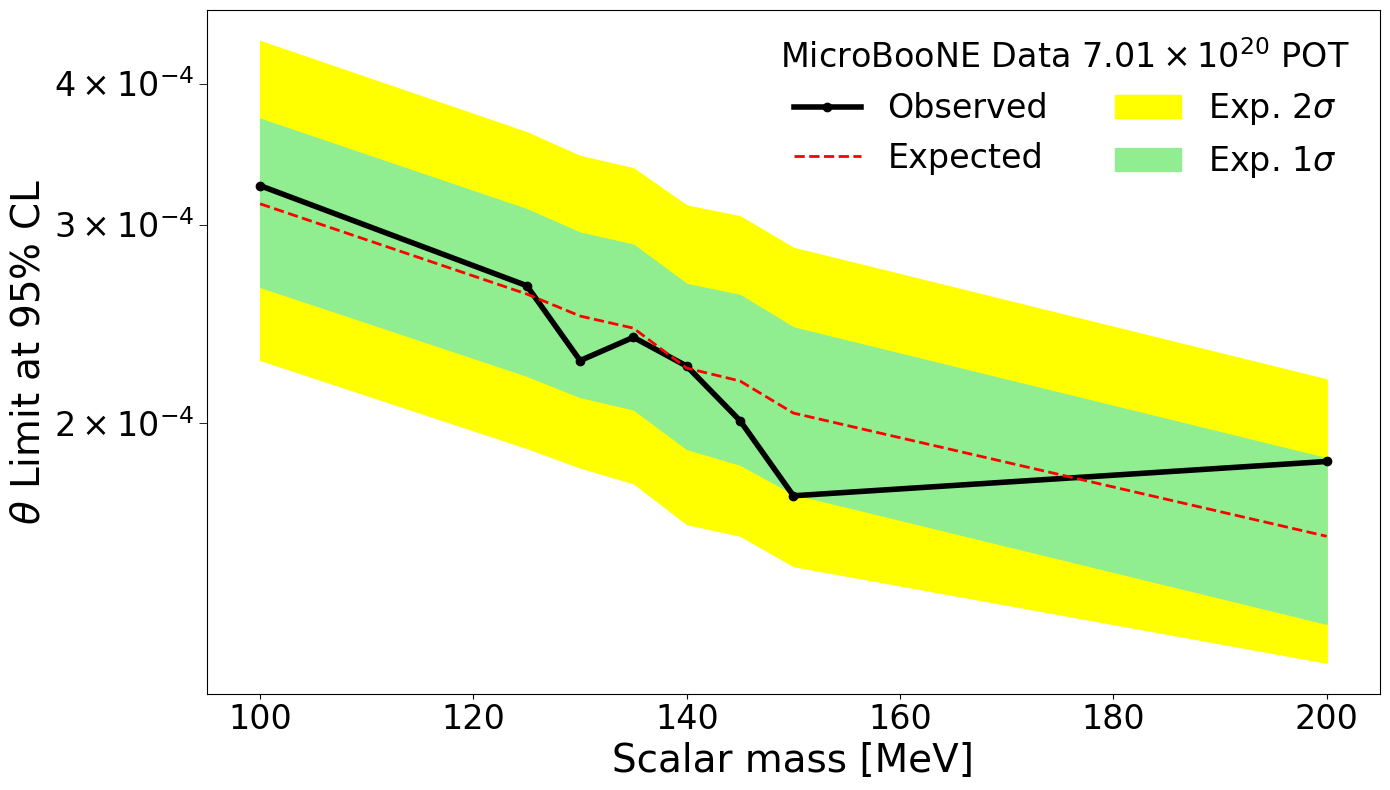

In [4]:
import matplotlib.patches as patches

run = 'all' # 'all', 'run1', 'run3', 'kdif', 'kdar', '1shr', '2shr'

TEST = False
scale_flux = 1.
scale_signal = 1.
scale_kdar = 1.


if run == 'all':
    filename=f"ALL_Capped_HPS_rebinned_limit"
elif run == 'stat':
    filename=f"stat_ALL_Capped_HPS_rebinned_limit"
elif run == 'run1':
    filename=f"Run1_Capped_HPS_rebinned_limit"
elif run == 'run3':
    filename=f"Run3_Capped_HPS_rebinned_limit"
elif run == 'kdif':
    filename=f"KDIF_Capped_HPS_rebinned_limit"
elif run == 'kdar':
    filename=f"KDAR_Capped_HPS_rebinned_limit"
elif run == '1shr':
    filename=f"1shr_Capped_HPS_rebinned_limit"
elif run == '2shr':
    filename=f"2shr_Capped_HPS_rebinned_limit"
elif run == 'kdar_run1':
    filename=f"KDAR_Capped_HPS_rebinned_limit"

if scale_signal != 1.:
    ext = "signal_scaled_{}_".format(Params_pyhf["Scale_signal_flux"])
    filename = ext + filename
    if type(Params_pyhf["Scale_bkg_neutrino_flux"]) == float:
        filename = filename.replace(".","_",1)
    

if scale_flux != 1.:
    ext = "flux_scaled_{}_".format(Params_pyhf["Scale_bkg_neutrino_flux"])
    filename = ext + filename
    if type(Params_pyhf["Scale_bkg_neutrino_flux"]) == float:
        filename = filename.replace(".","_",1)


if TEST:
    filename=f"test_{filename}"
    

elif run == 'separated':
    filename=f"separated_ALL_Capped_HPS_rebinned_limit"

ee_loaded_test = Get_sigma_bands(filename, RW=REWEIGHTING)
ee_limits_dict = Make_dicts_for_limits(ee_loaded_test)

ee_lims_dict, ee_mass_list = Make_list_limits(ee_loaded_test)

indices = []
for i in range(len(ee_lims_dict['exp_limit'])):
    if ee_lims_dict['exp_limit'][i] == ee_lims_dict['exp_1sig_up'][i]:
        indices.append(i)

for key in ee_lims_dict:
    for index in indices:
        ee_lims_dict[key] = np.delete(ee_lims_dict[key], index)

ee_mass_list = np.delete(ee_mass_list, indices)

# masses = np.array(ee_mass_list)

# indices = np.where((masses < 135) | (masses > 145))
# ee_mass_list = masses[indices]

# for key in ee_lims_dict.keys(): 
#     ee_lims_dict[key]=np.array(ee_lims_dict[key])[indices]

Aditya_thesis_observed = {100:3.08e-4, 150:2.9e-4, 200:2.31e-4}
Aditya_thesis_1sigup = [3.63e-4, 3.15e-4, 2.71e-4]
Aditya_thesis_2sigup = [3.97e-4, 3.48e-4, 3.00e-4]
Aditya_thesis_2sigdown = [2.69e-4, 2.35e-4, 2.03e-4]


Aditya_obs = np.array(list(Aditya_thesis_observed.values()))


titlename = r"MicroBooNE Data $7.01\times10^{20}$ POT"

plt.figure(figsize=(14,8),facecolor='white',dpi=100)

savefig = input("Do you want to save the figures? y/n ")

HNL_masses=ee_mass_list

plt.plot(HNL_masses,np.array(ee_lims_dict['obs_limit']),lw=4,ls='-',marker='o',color='black',label='Observed')
plt.plot(HNL_masses,np.array(ee_lims_dict['exp_limit']),lw=2,ls='--',color='red',label='Expected')
plt.fill_between(HNL_masses,np.array(ee_lims_dict['exp_2sig_down']),np.array(ee_lims_dict['exp_2sig_up']),color='yellow',label=r'Exp. 2$\sigma$')
plt.fill_between(HNL_masses,np.array(ee_lims_dict['exp_1sig_down']),np.array(ee_lims_dict['exp_1sig_up']),color='lightgreen',label=r'Exp. 1$\sigma$')



# plt.plot(HNL_masses, np.array(ee_scaled_limts_dict['exp_limit']), lw=2, ls='--', color='green', label='Expected (5/8 Scaled)')
# index_a = 3
# plt.plot(HNL_masses[:index_a],np.array(ee_lims_dict['obs_limit'])[:index_a],lw=4,ls='-',marker='o',color='black',label='Observed')
# plt.plot(HNL_masses[:index_a],np.array(ee_lims_dict['exp_limit'])[:index_a],lw=2,ls='--',color='red',label='Expected')
# plt.fill_between(HNL_masses[:index_a],np.array(ee_lims_dict['exp_2sig_down'])[:index_a],np.array(ee_lims_dict['exp_2sig_up'])[:index_a],color='yellow',label=r'Exp. 2$\sigma$')
# plt.fill_between(HNL_masses[:index_a],np.array(ee_lims_dict['exp_1sig_down'])[:index_a],np.array(ee_lims_dict['exp_1sig_up'])[:index_a],color='lightgreen',label=r'Exp. 1$\sigma$')

# plt.legend(loc="upper right",ncol=2,frameon=False,fontsize=22)
# if titlename != "": plt.legend(loc="upper right", ncol=2, frameon=False, fontsize=22, prop={'size': 24}, title=titlename, title_fontsize=24)


# index_b = 3
# plt.plot(HNL_masses[index_b:],np.array(ee_lims_dict['obs_limit'])[index_b:],lw=4,ls='-',marker='o',color='black',)
# plt.plot(HNL_masses[index_b:],np.array(ee_lims_dict['exp_limit'])[index_b:],lw=2,ls='--',color='red')
# plt.fill_between(HNL_masses[index_b:],np.array(ee_lims_dict['exp_2sig_down'])[index_b:],np.array(ee_lims_dict['exp_2sig_up'])[index_b:],color='yellow',)
# plt.fill_between(HNL_masses[index_b:],np.array(ee_lims_dict['exp_1sig_down'])[index_b:],np.array(ee_lims_dict['exp_1sig_up'])[index_b:],color='lightgreen',)
# plt.axvspan(130, 140, alpha=1, color='grey')

plt.legend(loc="upper right",ncol=2,frameon=False,fontsize=22)
if titlename != "": plt.legend(loc="upper right", ncol=2, frameon=False, fontsize=22, prop={'size': 24}, title=titlename, title_fontsize=24)

if REWEIGHTING == True:
    plt.ylabel(r'$c_\phi$ Limit at 95% CL',fontsize=28)
    plt.xlabel('ALP Mass [MeV]',fontsize=28)
else:
    plt.ylabel(r'$\theta$ Limit at 95% CL',fontsize=28)
    plt.xlabel('Scalar mass [MeV]',fontsize=28)


# plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24, which="major", length=10)
plt.tick_params(axis='y', labelsize=24, which="minor", length=6)

# plt.ylim(5e-5,1e-3)
# plt.ylim(1e-4,1e-1)


# plt.xlim(0,250)
plt.yscale('log')


plt.tight_layout()


if REWEIGHTING == True:
    if run == 'all':
        savename = f"ALL_Final_Capped_Rebinned_RW_Brazil_plot_excluded"
    elif run == 'run1':
        savename = f"Run1_Final_Capped_Rebinned_RW_Brazil_plot_excluded"
    ylims = [2e-5,1.5e-2]

    start = 125
    width = 20
    rect = patches.Rectangle((start,1.01*ylims[0]),width,0.99*ylims[-1],facecolor='lightgrey',fill=True,zorder=19, edgecolor='grey', ls='', label=r'$a-\pi^0$ Excluded Region')
    
    ax = plt.gca()
    ax.add_patch(rect)
    
else:
    if run == 'all':
        savename=f"ALL_Final_Capped_Rebinned_Brazil_plot"
    elif run == 'stat':
        savename=f"stat_ALL_Final_Capped_Rebinned_Brazil_plot"
    elif run == 'run1':
        savename=f"Run1_Final_Capped_Rebinned_Brazil_plot"
    elif run == 'run3':
        savename=f"Run3_Final_Capped_Rebinned_Brazil_plot"
    elif run == 'kdif':
        savename=f"KDIF_Final_Capped_Rebinned_Brazil_plot"
    elif run == 'kdar':
        savename=f"KDAR_Final_Capped_Rebinned_Brazil_plot"
    elif run == '1shr':
        savename=f"1shr_Final_Capped_Rebinned_Brazil_plot"
    elif run == '2shr':
        savename=f"2shr_Final_Capped_Rebinned_Brazil_plot"
    elif run == 'separated':
        savename=f"separated_ALL_Final_Capped_Rebinned_Brazil_plot"

if scale_kdar != 1.:
    ext = "kdar_signal_scaled_{}_".format(scale_kdar)
    savename = ext + savename
    if type(Params_pyhf["Scale_kdar_signal_flux"]) == float:
        savename = savename.replace(".","_",1)

# plt.axvspan(130, 140, alpha=1, color='grey',lw=1, label=r'$a-\pi^0$ Excluded Region')

if savefig == "y":
    plt.savefig(root_dir+'Plots/Limits/'+savename+'.pdf',bbox_inches='tight', pad_inches=0.3)
    plt.savefig(root_dir+'Plots/Limits/'+savename+'.png',bbox_inches='tight', pad_inches=0.3)

# plt.grid(False)

In [10]:
i=0
for mass in ee_mass_list:
    print('Mass = ', mass)
    obs = ee_lims_dict['obs_limit'][i]
    exp = ee_lims_dict['exp_limit'][i]
    sig_up = ee_lims_dict['exp_1sig_up'][i] - exp
    sig_down = exp - ee_lims_dict['exp_1sig_down'][i]

    print('Obs = ',ee_lims_dict['obs_limit'][i])
    print('Exp = ',exp)
    print('1sig up = ',sig_up)
    print('1sig down = ',sig_down)
    print()
    i+=1
    

Mass =  100
Obs =  0.00032476026638060437
Exp =  0.00031292958883676265
1sig up =  5.932603751037909e-05
1sig down =  4.8771513501796556e-05

Mass =  125
Obs =  0.000264777711846125
Exp =  0.0002602987966939908
1sig up =  4.918891269318728e-05
1sig down =  3.995373060848562e-05

Mass =  130
Obs =  0.0002272301500866692
Exp =  0.00024886886425703407
1sig up =  4.6171690101453645e-05
1sig down =  3.7891883921867253e-05

Mass =  135
Obs =  0.00023829230685017583
Exp =  0.00024278531128819883
1sig up =  4.508198562401487e-05
1sig down =  3.7064487071223424e-05

Mass =  140
Obs =  0.00022467314446271826
Exp =  0.0002237828151275258
1sig up =  4.187279275970685e-05
1sig down =  3.404301030105207e-05

Mass =  145
Obs =  0.00020098671436547593
Exp =  0.00021794192375029385
1sig up =  4.180327099755158e-05
1sig down =  3.4168960159542045e-05

Mass =  150
Obs =  0.00017243205948256197
Exp =  0.00020414409340075722
1sig up =  3.897119494735847e-05
1sig down =  3.1002022853135046e-05

Mass =  200


In [46]:
print(savename)

ALL_Final_Capped_Rebinned_RW_Brazil_plot_excluded


In [47]:
# HNL_masses,np.array(ee_lims_dict['exp_1sig_down']),np.array(ee_lims_dict['exp_1sig_up'])

for i,mass in enumerate(HNL_masses):
    print(mass)

    obs_limit = ee_lims_dict['obs_limit'][i]
    limit = ee_lims_dict['exp_limit'][i]
    upper_unc = ee_lims_dict['exp_1sig_up'][i]-ee_lims_dict['exp_limit'][i]
    lower_unc = ee_lims_dict['exp_limit'][i]-ee_lims_dict['exp_1sig_down'][i]
    print('obs limit = {:.3}'.format(obs_limit))
    print('exp limit = {:.3} + {:.2} - {:.2}'.format(limit, upper_unc, lower_unc))

    print()

100
obs limit = 0.00231
exp limit = 0.00215 + 0.00041 - 0.00033

125
obs limit = 0.00297
exp limit = 0.0028 + 0.00054 - 0.00044

130
obs limit = 0.00457
exp limit = 0.00502 + 0.00085 - 0.00071

140
obs limit = 0.0084
exp limit = 0.0084 + 9.5e-07 - 1.4e-06

145
obs limit = 0.00249
exp limit = 0.00262 + 0.00051 - 0.00041

150
obs limit = 0.0017
exp limit = 0.00194 + 0.00038 - 0.00031

200
obs limit = 0.00144
exp limit = 0.00119 + 0.00022 - 0.00019



## Using separated pyhf model over 1 mass point

In [ ]:
# In this section, the aim is to use the full, separated uncertainties of the model, which is significantly slower.
# Therefore, the point of this section is to verify how much the results change when using the full uncertainties,
# ideally being consistent with the quicker method.


model_dict = create_model_dict_separated(Total_dict)

DATA_OBS_dict = {}

for HNL_mass in model_dict:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only
    list_keys = list(Total_dict[HNL_mass].keys())
    
    
    list_keys = list(Total_dict[HNL_mass].keys())
    if "data" in list_keys: #haven't made this yet, need to test
        DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["data"]+model_dict[HNL_mass].config.auxdata
    else:
        DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]['TOT_BKG_VALS']+model_dict[HNL_mass].config.auxdata
#Should take ~10 mins for each with 5 bins, 100 mu values
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of an upper limit calculation is equal to the lowest or highest value of poi, the range needs to be extended")

# poi_values = np.linspace(1000, 10000,10) #Values of mu which are scanned over in hypo tests. Default: np.linspace(0.001, 2, 100)
# print("Max value is " + str(max(poi_values)))
# print("Min value is " + str(min(poi_values)))
# print("Next value is " + str(poi_values[1]))
# print("Next value is " + str(poi_values[2]) + "\n")

print("-----Starting Hypothesis tests-----" + "\n")
CL_level = 0.05
print(f"CLs CL is {(1-CL_level)*100}%")

if CL_level != 0.05: print("WARNING, the CL should usually be 95%, here it is not.")
print()

num_steps = 100

if REWEIGHTING == True:
    # dict needs to cover a larger range depending on mass, due to axion-pion mixing 
    # which suppresses leptonic decays near 135 MeV.
    poi_dict = {
        100:np.linspace(0.001, 2, num_steps),
        125:np.linspace(0.001, 5, num_steps),
        130:np.linspace(1, 2000, num_steps),
        135:np.linspace(1, 10000, num_steps),
        140:np.linspace(1, 10000, num_steps),
        145:np.linspace(0.01, 10, num_steps),
        150:np.linspace(0.001, 5, num_steps),
        200:np.linspace(0.001, 5, num_steps),
    }
else: 
    poi_dict = {
        100:np.linspace(0.001, 2, num_steps),
        125:np.linspace(0.001, 2, num_steps),
        130:np.linspace(0.001, 2, num_steps),
        135:np.linspace(0.001, 2, num_steps),
        140:np.linspace(0.001, 2, num_steps),
        145:np.linspace(0.001, 2, num_steps),
        150:np.linspace(0.001, 2, num_steps),
        200:np.linspace(0.001, 2, num_steps),
    }

masses = [100] # selecting only one mass point to iterate over

for mass in masses:
    poi_values = poi_dict[HNL_mass]

    print("Max value is " + str(max(poi_values)))
    print("Min value is " + str(min(poi_values)))
    print("Next value is " + str(poi_values[1]))
    print("Next value is " + str(poi_values[2]) + "\n")

    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=CL_level, return_results=True
    )

    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.6f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.6f}" + "\n")

if REWEIGHTING:
    save_loc = "limit_files/RW_Brazil_plot/"
else: 
    save_loc = "limit_files/Brazil_plot/"
to_save_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
to_save_lists = [exp_1sig_up,exp_1sig_down,exp_2sig_up,exp_2sig_down,exp_limit,obs_limit]

if run == 'all':
    filename=f"_ALL_Capped_HPS_rebinned_limit.csv"
elif run == 'run1':
    filename=f"_Run1_Capped_HPS_rebinned_limit.csv"
elif run == 'run3':
    filename=f"_Run3_Capped_HPS_rebinned_limit.csv"
elif run == 'kdif':
    filename=f"_KDIF_Capped_HPS_rebinned_limit.csv"
elif run == 'kdar':
    filename=f"_KDAR_Capped_HPS_rebinned_limit.csv"
elif run == '1shr':
    filename=f"_1shr_Capped_HPS_rebinned_limit.csv"
elif run == '2shr':
    filename=f"_2shr_Capped_HPS_rebinned_limit.csv"

for i, lim in enumerate(to_save_lists):

    r = zip(masses, lim)
    savestr=to_save_names[i]
    savename = "separated_"+save_loc+savestr+filename
    with open(savename, "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)

print("Last saved is " + savename)

# OLDER CODE: Just using output BDT hists from Aditya (no re-binning)

In [ ]:
def Load_BDT_scores(locs, labels):
    """
    Read the BDT score histograms saved in the .root files in the locs argument.
    Returns a dictionary of the histograms.
    """
    hist_dict, bins_dict = {}, {}
    for loc in locs:
        SIG = uproot.open(loc)['Signal_CV0'].values()
        SIG_ERR = uproot.open(loc)['Signal_Fluct_Up0'].values()*SIG
        MC_BKG = uproot.open(loc)['Bkg_CV0'].values()
        MC_BKG_ERR = uproot.open(loc)['Bkg_Fluct_Up0'].values()*MC_BKG
        EXT = uproot.open(loc)['Bkg_EXT_CV0'].values()
        EXT_ERR = np.sqrt(EXT)
        BKG = MC_BKG+EXT
        BKG_ERR = np.sqrt(MC_BKG_ERR**2 + EXT_ERR**2) #Adding uncetainties in quadrature (uncorrelated)
        DATA = uproot.open(loc)['Data_CV0'].values()
        DATA_ERR = uproot.open(loc)['Data_CV0'].errors()*DATA
        
        BINS = uproot.open(loc)['Signal_CV0'].to_numpy()[1]
        
        hist_dict[labels[loc]]={'TOT_SIGNAL_VALS':SIG, 'TOT_BKG_VALS':BKG, 'TOT_SIGNAL_ERR':SIG_ERR, 'TOT_BKG_ERR':BKG_ERR, "data":DATA}
        bins_dict[labels[loc]]=BINS
        
    return hist_dict, bins_dict


def Make_hist_dict_from_Total_dict(Total_dict):
    """
    Creating a dict of just hists from Total dict.
    For the purposes of creating bins.
    """
    bins_dict, bins_cents_dict = {}, {}
    for HNL_mass in Total_dict:
        bins = np.arange(len(Total_dict[HNL_mass]['TOT_BKG_VALS'])+1)
        bin_cents = (bins[:-1]+bins[1:])/2
        bins_dict[HNL_mass] = bins
        bins_cents_dict[HNL_mass] = bin_cents
        
    return bins_dict, bins_cents_dict

def make_bins_dicts(hist_dict, Params, bins_dict):
    """
    Given a histogram dict returns the bins and bin centres dictionaries.
    """
    bins_dict, bins_cents_dict = {}, {}
    if Params["Use_part_only"] == False:
        for HNL_mass in hist_dict:
            bins = Total_bins_dict[HNL_mass]
            bin_cents = (bins[:-1]+bins[1:])/2
            bins_dict[HNL_mass] = bins
            bins_cents_dict[HNL_mass] = bin_cents
    if Params["Use_part_only"] == True:
        for HNL_mass in hist_dict:
            Num_bins=Params["Num_bins_for_calc"]
            bins = Total_bins_dict[HNL_mass]
            bins = bins[-1*(Num_bins+1):]
            bin_cents = (bins[:-1]+bins[1:])/2
            bins_dict[HNL_mass] = bins
            bins_cents_dict[HNL_mass] = bin_cents
            
    return bins_dict, bins_cents_dict

def remove_part_hist(hist_list, numbins):
        length = len(hist_list)
        slice_at = length - int(numbins)
        if slice_at < 0:
            print("Trying to use greater number of bins than available, using full dist.")
            return hist_list
        else:
            sliced_hist = hist_list[slice_at:]
            return sliced_hist
        

In [ ]:
# HPS_masses = [100, 125, 130, 135, 140, 145, 150, 200]
HPS_masses = [100, 150, 200]

locs_list = []
locs_labels_dict = {}

Use_both_runs = False

if Use_both_runs==True: 
    Run_list = ["R1", "R3"]
    print("Using BOTH runs")

else: 
    Run_list = ["R3"]
    print("Using " + str(Run_list) + " only.")

for HPS_mass in HPS_masses:
    for Run_name in Run_list:
        locs_list.extend([f"../files/BDT_output/TMP_{HPS_mass}_{Run_name}_KDAR_1shw.root", f"../files/BDT_output/TMP_{HPS_mass}_{Run_name}_KDAR_2shw.root",
            f"../files/BDT_output/TMP_{HPS_mass}_{Run_name}_KDIF_1shw.root", f"../files/BDT_output/TMP_{HPS_mass}_{Run_name}_KDIF_2shw.root"])
    
        locs_labels_dict.update({f"../files/BDT_output/TMP_{HPS_mass}_{Run_name}_KDAR_1shw.root":f"{HPS_mass}_{Run_name}_KDAR_1shw",
                                 f"../files/BDT_output/TMP_{HPS_mass}_{Run_name}_KDAR_2shw.root":f"{HPS_mass}_{Run_name}_KDAR_2shw",
                                 f"../files/BDT_output/TMP_{HPS_mass}_{Run_name}_KDIF_1shw.root":f"{HPS_mass}_{Run_name}_KDIF_1shw",
                                 f"../files/BDT_output/TMP_{HPS_mass}_{Run_name}_KDIF_2shw.root":f"{HPS_mass}_{Run_name}_KDIF_2shw"})


In [ ]:
hist_dict_test, bins_test = Load_BDT_scores(locs_list, locs_labels_dict)

Total_bins_dict, Total_bins_cent_dict = Make_hist_dict_from_Total_dict(hist_dict_test)

bins_dict, bins_cent_dict = make_bins_dicts(hist_dict_test, Params_pyhf, Total_bins_dict)


In [34]:
#Checking which bins to merge
merged_bins_dict, bin_cents = {}, {}
max_scores, min_scores = [], []

for HNL_mass in bins_test:
    max_scores.append(max(bins_test[HNL_mass]))
    min_scores.append(min(bins_test[HNL_mass]))
    
min_score_cut = min(min_scores)
max_score_int = max(max_scores)
xlims = [min_score_cut,max_score_int]
nbins = len(bins_test[HNL_mass])-1
min_bkg = 1.0 #The threshold of minimum bkg events required in a bin, used to be 1
print("Initial nbins is " + str(nbins))
print("With range of " + str(xlims))
print(f"Requiring more than {min_bkg} bkg events in each bin")

bkg_unc_estimated = 0.4
signal_unc_estimated = 0.25

print("For the overflow bin, estimated uncertainties are being used!")
print(f"Estimated bkg uncertainty is {bkg_unc_estimated*100}%, Estimated signal uncertainty is {signal_unc_estimated*100}%.")

merged_hist_dict = {}

for HNL_mass in bins_test:
    bins_list = bins_test[HNL_mass]
    bin_spacing = bins_test[HNL_mass][1]-bins_test[HNL_mass][0]
    
    totbkg=hist_dict_test[HNL_mass]['TOT_BKG_VALS']
    tot_signal = hist_dict_test[HNL_mass]['TOT_SIGNAL_VALS']

    bins_new=[]
    for i,bin_bkg in enumerate(totbkg):
        if(totbkg[i]>min_bkg): #Checking if unweighted overlay bkg has at least one event in the bin
            bins_new.append(bins_list[i])

    bins_new.append(bins_list[-1])
    merged_bins_dict[HNL_mass] = bins_new
    #Making spacing of overflow bin equal to other spacings
    merged_bins_dict[HNL_mass][-1] = merged_bins_dict[HNL_mass][-2]+bin_spacing
    bin_cents[HNL_mass] = (np.array(bins_new[:-1])+np.array(bins_new[1:]))/2
    
    threshold = bins_new[-2]
    threshold_bin = len(bins_new)-2
    
    vals_new_bkg, vals_new_signal, vals_new_data = [], [], []
    overflow_sum_bkg, overflow_sum_signal, overflow_sum_data = 0.0, 0.0, 0.0
    bkg_err_new, signal_err_new = [], []
    
    for i,bkg_val in enumerate(totbkg):
        if(i<threshold_bin): #Checking if unweighted overlay bkg has at least one event in the bin
            vals_new_bkg.append(totbkg[i])
            vals_new_signal.append(tot_signal[i])
            vals_new_data.append(hist_dict_test[HNL_mass]['data'][i])
            bkg_err_new.append(hist_dict_test[HNL_mass]['TOT_BKG_ERR'][i])
            signal_err_new.append(hist_dict_test[HNL_mass]['TOT_SIGNAL_ERR'][i])
        else: 
            overflow_sum_bkg+=totbkg[i]
            overflow_sum_signal+=tot_signal[i]
            overflow_sum_data+=hist_dict_test[HNL_mass]['data'][i]
    vals_new_bkg.append(overflow_sum_bkg)
    vals_new_signal.append(overflow_sum_signal)
    vals_new_data.append(overflow_sum_data)
    print(np.shape(vals_new_data))
    bkg_err_new.append(bkg_unc_estimated*overflow_sum_bkg)
    signal_err_new.append(signal_unc_estimated*overflow_sum_signal)

    merged_hist_dict[HNL_mass] = {'TOT_SIGNAL_VALS':vals_new_signal, 'TOT_BKG_VALS':vals_new_bkg, 
                                  'TOT_SIGNAL_ERR':signal_err_new, 'TOT_BKG_ERR':bkg_err_new, "data":vals_new_data}
    

NameError: name 'bins_test' is not defined

In [ ]:
for label in merged_hist_dict:
    for hist in merged_hist_dict[label]:
        merged_hist_dict[label][hist] = remove_part_hist(list(merged_hist_dict[label][hist]), Params_pyhf["Num_bins_for_calc"])
        merged_bins_dict[label] = remove_part_hist(list(merged_bins_dict[label]), Params_pyhf["Num_bins_for_calc"]+1)
        bin_cents[label] = remove_part_hist(list(bin_cents[label]), Params_pyhf["Num_bins_for_calc"])


In [ ]:
def Create_final_appended_runs_dict(list_input_dicts):
    
    def append_list_of_lists(input_list):
        output_list = []
        for i in range(len(input_list)):
            output_list = output_list + input_list[i]
        return output_list

    Total_dict = {}
    all_keys = list(list_input_dicts[0].keys())
    first_key = all_keys[0]

    Appended_dict = {}
    for dict_type in list_input_dicts[0].keys():
        list_placeholder = []
        for input_dict in list_input_dicts: #This loops over the dicts for different runs
            list_placeholder.append(input_dict[dict_type]) 
        Appended = append_list_of_lists(list_placeholder)
        Appended_dict[dict_type] = Appended
    Total_dict = Appended_dict
        
    return Total_dict

Total_dict = {}

for HPS_mass in HPS_masses:
    for Run_name in Run_list:
        Total_dict[HPS_mass] = Create_final_appended_runs_dict([merged_hist_dict[f'{HPS_mass}_{Run_name}_KDAR_1shw'], merged_hist_dict[f'{HPS_mass}_{Run_name}_KDAR_2shw'], 
                                                            merged_hist_dict[f'{HPS_mass}_{Run_name}_KDIF_1shw'], merged_hist_dict[f'{HPS_mass}_{Run_name}_KDIF_2shw']])


## Plotting original histograms

In [ ]:
def Get_channel_info(channel):
    """
    Given a string of the channel returns HPS mass, Run, K_state, n_shr.
    """
    split_out = channel.split("_")
    mass = split_out[0]
    Run = split_out[1]
    K_state = split_out[2]
    n_shr = split_out[3]
    
    if Run == "R1": Run = "Run1"
    if Run == "R3": Run = "Run3"
    
    if n_shr == "1shw": n_shr = "1"
    if n_shr == "2shw": n_shr = "2"
    
    return mass, Run, K_state, n_shr


In [ ]:
#Plotting histograms before setting limit
original_hists = hist_dict_test

signal_scale = 5.0

save_plots = input("Do you want to save the plots? y/n ")

plt.rcParams['font.size'] = 16
for channel in hist_dict_test.keys():
    plt.figure(figsize=(10,6),facecolor='white',dpi=100)
    
    mass, Run, K_state, n_shr = Get_channel_info(channel)

    num_bins = len(original_hists[channel]['TOT_BKG_VALS'])

    bins = bins_test[channel]
    bins_cents_list = (bins[:-1]+bins[1:])/2
    
    sig_sum = sum(original_hists[channel]['TOT_SIGNAL_VALS'])
    bkg_sum = sum(original_hists[channel]['TOT_BKG_VALS'])
    # EXT_sum = sum(Total_dict[channel]['EXT_VALS'])
    data_sum = sum(original_hists[channel]['data'])
    
    bkg_vals = original_hists[channel]['TOT_BKG_VALS']
    bkg_err = np.array(original_hists[channel]['TOT_BKG_ERR'])
    sig_vals = original_hists[channel]['TOT_SIGNAL_VALS'] 
    sig_err = np.array(original_hists[channel]['TOT_SIGNAL_VALS'])

    plt.hist(bins_cents_list, weights=original_hists[channel]['TOT_SIGNAL_VALS']*signal_scale, bins=bins, histtype="step", lw=2, label=f"{mass} MeV HPS ({round(sig_sum*signal_scale, 1)} = KOTO CV x {signal_scale})")
    plt.hist(bins_cents_list, weights=original_hists[channel]['TOT_BKG_VALS'], bins=bins, histtype="step",lw=2, label=f"Total Background ({round(bkg_sum, 1)})")

    bkg_up=np.append((bkg_vals+bkg_err),(bkg_vals+bkg_err)[-1])
    bkg_down=np.append((bkg_vals-bkg_err),(bkg_vals-bkg_err)[-1])
    sig_up=np.append((sig_vals*signal_scale+sig_err*signal_scale),(sig_vals*signal_scale+sig_err*signal_scale)[-1])
    sig_down=np.append((sig_vals*signal_scale-sig_err*signal_scale),(sig_vals*signal_scale-sig_err*signal_scale)[-1])

    plt.fill_between(bins, bkg_down, bkg_up,step="post",hatch='///',alpha=0,zorder=2)
    plt.fill_between(bins, sig_down, sig_up,step="post",hatch='///',alpha=0,zorder=2)
    
    x,y=np.histogram(bins_cents_list,weights=original_hists[channel]['data'],bins=bins)
    dat_placeholder=x
    dat_err=np.sqrt(x)
        
    plt.errorbar(bins_cents_list, dat_placeholder, yerr=dat_err, fmt='.',color='black',lw=5,capsize=5,elinewidth=3,label=f"Data ({data_sum})")

    # plt.yscale("log")
    plt.legend(title=f"{mass} MeV {Run} {K_state} {n_shr} shower(s)")
    plt.xlabel("BDT score", fontsize=22)
    plt.ylabel("Events", fontsize=22)
    
    plt.tight_layout()
    
    if save_plots == "y":
        plt.savefig(f"../Plots/BDT_output_scores/Original_scores_{mass}_{Run}_{K_state}_{n_shr}_showers.png")
        plt.savefig(f"../Plots/BDT_output_scores/Original_scores_{mass}_{Run}_{K_state}_{n_shr}_showers.pdf")
    
    plt.close()
    # plt.show()
    

## Scaling signal

In [ ]:
signal_SF_dict = {100:5.0, 125:4.0, 130:3.0, 135:3.0, 140:2.0, 145:2.0, 150:2.0, 200:1.0}
theta_CV_dict = {100:5.36e-4, 125:5.5e-4, 130:5.54e-4, 135:5.58e-4, 140:5.63e-4, 145:5.68e-4, 150:5.73e-4, 200:6.58e-4} 

# Total_dict_scaled, new_theta_dict = copy.deepcopy(Total_dict), {}

scaled_Total_dict = copy.deepcopy(Total_dict)
scaled_theta_CV_dict = {}

for HPS_mass in Total_dict:
    scaled_Total_dict[HPS_mass]['TOT_SIGNAL_VALS'] = np.array(Total_dict[HPS_mass]['TOT_SIGNAL_VALS'])*signal_SF_dict[HPS_mass]
    scaled_Total_dict[HPS_mass]['TOT_SIGNAL_ERR'] = np.array(Total_dict[HPS_mass]['TOT_SIGNAL_ERR'])*signal_SF_dict[HPS_mass]
    
    scaled_theta_CV_dict[HPS_mass] = theta_CV_dict[HPS_mass]*np.sqrt(signal_SF_dict[HPS_mass])
    

In [ ]:
print(scaled_Total_dict[HPS_mass]['TOT_SIGNAL_VALS'])
print(scaled_theta_CV_dict)

## Plotting merged histograms

In [ ]:
plt.rcParams['font.size'] = 16

plot_dict = scaled_Total_dict

save_plots = input("Do you want to save the plots? y/n")

for HPS_mass in Total_dict:

    plt.figure(figsize=(10,6),facecolor='white',dpi=100)
    num_bins = len(Total_dict[HPS_mass]['TOT_BKG_VALS'])

    #Appending bins.... Just make ints
    bins_ints = np.arange(0,num_bins+1,1)
    bins = bins_ints
    bins_cents_list = (bins[:-1]+bins[1:])/2

    plt.hist(bins_cents_list, weights=plot_dict[HPS_mass]['TOT_SIGNAL_VALS'], bins=bins, histtype="step", lw=2, label=f"Signal {HPS_mass} MeV")
    plt.hist(bins_cents_list, weights=plot_dict[HPS_mass]['TOT_BKG_VALS'], bins=bins, histtype="step",lw=2, label="Total Background")

    bkg_up=np.append((plot_dict[HPS_mass]['TOT_BKG_VALS']+np.array(plot_dict[HPS_mass]['TOT_BKG_ERR'])),(plot_dict[HPS_mass]['TOT_BKG_VALS']+np.array(plot_dict[HPS_mass]['TOT_BKG_ERR']))[-1])
    bkg_down=np.append((plot_dict[HPS_mass]['TOT_BKG_VALS']-np.array(plot_dict[HPS_mass]['TOT_BKG_ERR'])),(plot_dict[HPS_mass]['TOT_BKG_VALS']-np.array(plot_dict[HPS_mass]['TOT_BKG_ERR']))[-1])
    sig_up=np.append((plot_dict[HPS_mass]['TOT_SIGNAL_VALS']+np.array(plot_dict[HPS_mass]['TOT_SIGNAL_ERR'])),(plot_dict[HPS_mass]['TOT_SIGNAL_VALS']+np.array(plot_dict[HPS_mass]['TOT_SIGNAL_ERR']))[-1])
    sig_down=np.append((plot_dict[HPS_mass]['TOT_SIGNAL_VALS']-np.array(plot_dict[HPS_mass]['TOT_SIGNAL_ERR'])),(plot_dict[HPS_mass]['TOT_SIGNAL_VALS']-np.array(plot_dict[HPS_mass]['TOT_SIGNAL_ERR']))[-1])

    plt.fill_between(bins, bkg_down, bkg_up,step="post",hatch='///',alpha=0,zorder=2)
    plt.fill_between(bins, sig_down, sig_up,step="post",hatch='///',alpha=0,zorder=2)

    x,y=np.histogram(bins_cents_list,weights=plot_dict[HPS_mass]['data'],bins=bins)
    dat_placeholder=x
    dat_err=np.sqrt(x)

    plt.errorbar(bins_cents_list, dat_placeholder, yerr=dat_err, fmt='.',color='black',lw=5,capsize=5,elinewidth=3,label=f"Data")

    # plt.yscale("log")
    plt.legend()
    plt.xlabel("Bin number (appended BDT scores)", fontsize=22)
    plt.ylabel("Events", fontsize=22)

    plt.tight_layout()

    if save_plots == "y":
        plt.savefig(f"../Plots/BDT_output_scores/Merged_bins_scores_{HPS_mass}_{Run}_appended.png")
        plt.savefig(f"../Plots/BDT_output_scores/Merged_bins_scores_{HPS_mass}_{Run}_appended.pdf")

    plt.show()
    plt.close()


In [ ]:
test_mass = 200
print(Total_dict[test_mass].keys())

print(len(Total_dict[test_mass]['TOT_SIGNAL_VALS']))

## Calculating limit

In [ ]:
def create_model_dict_same(Total_dict, debug=False):
    """
    Creating a model where the uncertainties are all enveloped in one shapesys modifier for signal and bkg.
    The total errors are taken from \"TOT_SIGNAL_ERR\" and \"TOT_BKG_ERR\" respectively.
    """
    model_dict = {}
    
    for HNL_mass in Total_dict:
        if(debug):print(HNL_mass)
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": list(Total_dict[HNL_mass]['TOT_SIGNAL_VALS']),#Don't know if I need to make this to a list
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": list(Total_dict[HNL_mass]["TOT_SIGNAL_ERR"])}
              ]
            },
            {
              "name": "background",
              "data": list(Total_dict[HNL_mass]['TOT_BKG_VALS']),
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": list(Total_dict[HNL_mass]["TOT_BKG_ERR"])}
              ]
            }
          ]
        }
      ]
    }
    )
    return model_dict

def create_model_dict_one_mass(Total_dict, debug=False):
    """
    Creating a model where the uncertainties are all enveloped in one shapesys modifier for signal and bkg.
    The total errors are taken from \"TOT_SIGNAL_ERR\" and \"TOT_BKG_ERR\" respectively.
    """
    model_dict = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": list(Total_dict['TOT_SIGNAL_VALS']),#Don't know if I need to make this to a list
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None}, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": list(Total_dict["TOT_SIGNAL_ERR"])}
              ]
            },
            {
              "name": "background",
              "data": list(Total_dict['TOT_BKG_VALS']),
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": list(Total_dict["TOT_BKG_ERR"])}
              ]
            }
          ]
        }
      ]
    }
    )
    return model_dict



In [ ]:
single_mass = 150

model_dict_single = create_model_dict_one_mass(scaled_Total_dict[single_mass]) #scaled_Total_dict,Total_dict
model_dict_test = create_model_dict_same(scaled_Total_dict)

print("Created models \n")

print(f'Samples:\n {model_dict_test[single_mass].config.samples}')
print(f'Modifiers are:\n {model_dict_test[single_mass].config.modifiers}')


## Testing single point

In [ ]:
#Testing single point

HNL_mass = single_mass #The mass point to test
n_sigmas = 2
if n_sigmas==1: sigma_list = np.arange(-1, 2)
if n_sigmas==2: sigma_list = np.arange(-2, 3)

model_dict_to_use = model_dict_single
# Total_dict_to_use = Total_dict_run1_scaled #Total_dict_both, Total_dict_run1, Total_dict_run3
Total_dict_to_use = scaled_Total_dict[single_mass]

DATA_OBS_dict = {}
obs_limit_dict = {}
exp_limits_dict = {}
init_pars = model_dict_to_use.config.suggested_init()
model_dict_to_use.expected_actualdata(init_pars) #signal plus bkg

bkg_pars = init_pars.copy()
bkg_pars[model_dict_to_use.config.poi_index] = 0
model_dict_to_use.expected_actualdata(bkg_pars) #bkg only

if 'data' not in Total_dict_to_use.keys(): 
    print("No data in this sample, using bkg as data")
    DATA_OBS_dict = list(Total_dict_to_use['TOT_BKG_VALS'])+model_dict_to_use.config.auxdata
else: 
    print("Using real data for observed limit")
    DATA_OBS_dict = list(Total_dict_to_use["data"])+model_dict_to_use.config.auxdata    

model_dict_to_use.logpdf(pars=bkg_pars, data=DATA_OBS_dict) #Is this only for the test stat distribution stuff?
    
poi_values = np.linspace(0.001, 3.0, 100) 
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")

CL_level = 0.05
print(f"CLs CL is {(1-CL_level)*100}%")
obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(DATA_OBS_dict, 
                                                                                       model_dict_to_use, poi_values, 
                                                                                       level=CL_level, return_results=True)

print(f"Upper limit (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit (exp): μ = {exp_limits_single[2]:.4f}" + "\n")


In [52]:
theta_CV_dict = {100:5.36e-4, 125:5.5e-4, 130:5.54e-4, 135:5.58e-4, 140:5.63e-4, 145:5.68e-4, 150:5.73e-4, 200:6.58e-4} 

theta = scaled_theta_CV_dict[single_mass]

#N events scales with mixing angle squared
obs_limit = np.sqrt(obs_limit_single)*theta
exp_limit = np.sqrt(exp_limits_single[2])*theta

exp_1sig_up, exp_2sig_up, exp_1sig_down, exp_2sig_down = [], [], [], []

exp_1sig_up.append(np.sqrt(exp_limits_single[3])*theta)
exp_2sig_up.append(np.sqrt(exp_limits_single[4])*theta)
exp_1sig_down.append(np.sqrt(exp_limits_single[1])*theta)
exp_2sig_down.append(np.sqrt(exp_limits_single[0])*theta)


NameError: name 'single_mass' is not defined

In [ ]:
print(f"Observed: {obs_limit}")
print(f"Expected: {exp_limit}")
print(f"1sig up mu: {exp_limits_single[3]}")
print(f"1sig down mu: {exp_limits_single[1]}")
print(f"2sig up mu: {exp_limits_single[4]}")
print(f"2sig down mu: {exp_limits_single[0]}")

HPS_masses = [149, 151]

ee_lims_dict={}
ee_lims_dict['obs_limit'] = [obs_limit, obs_limit]
ee_lims_dict['exp_limit'] = [exp_limit, exp_limit]
ee_lims_dict['exp_2sig_down'] = [exp_2sig_down[0], exp_2sig_down[0]]
ee_lims_dict['exp_2sig_up'] = [exp_2sig_up[0], exp_2sig_up[0]]
ee_lims_dict['exp_1sig_down'] = [exp_1sig_down[0], exp_1sig_down[0]]
ee_lims_dict['exp_1sig_up'] = [exp_1sig_up[0], exp_1sig_up[0]]


In [ ]:
plt.figure(figsize=(14,8),facecolor='white',dpi=100)

# savefig = True
titlename=""

plt.plot(HPS_masses,np.array(ee_lims_dict['obs_limit']),lw=4,ls='-',color='black',label='Observed')
plt.plot(HPS_masses,np.array(ee_lims_dict['exp_limit']),lw=2,ls='--',color='red',label='Expected')
plt.fill_between(HPS_masses,np.array(ee_lims_dict['exp_2sig_down']),np.array(ee_lims_dict['exp_2sig_up']),color='yellow',label=r'Exp. 2$\sigma$')
plt.fill_between(HPS_masses,np.array(ee_lims_dict['exp_1sig_down']),np.array(ee_lims_dict['exp_1sig_up']),color='lightgreen',label=r'Exp. 1$\sigma$')

plt.scatter(150, 2.9e-4, label="Aditya observed")

plt.ylabel(r'$|U_{\mu 4}|^2$ Limit at 90% CL',fontsize=22)
plt.xlabel('HPS Mass [MeV]',fontsize=22)

plt.ylim(1e-4,1e-3)
plt.legend(loc="lower left",ncol=2,frameon=False,fontsize=22)
if titlename != "": plt.legend(loc="lower left", ncol=2, frameon=False, fontsize=22, prop={'size': 22}, title=titlename, title_fontsize=22)
# plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlim(145,155)
# plt.xlim(0,250)
plt.yscale('log')

plt.tight_layout()

savename = f"merged_observed"

# if savefig == True:
#     plt.savefig('plots/Limits/'+savename+'.pdf',bbox_inches='tight', pad_inches=0.3)
#     plt.savefig('plots/Limits/'+savename+'.png',bbox_inches='tight', pad_inches=0.3)

plt.grid(False)


## Using all mass points

In [ ]:
print(HPS_masses)

In [ ]:
#Testing several mass points
n_sigmas = 2
if n_sigmas==1: sigma_list = np.arange(-1, 2)
if n_sigmas==2: sigma_list = np.arange(-2, 3)

model_dict_to_use = model_dict_test

Total_dict_to_use = Total_dict

mass_list = [100, 125, 135, 140, 145, 150, 200]
working = [100, 125, 135, 140, 145, 150, 200]
not_working = [130]

DATA_OBS_dict = {}
obs_limit_dict = {}
exp_limits_dict = {}
    
# for HNL_mass in model_dict_test: #Doing full mass range
for HNL_mass in mass_list: #Only doing a subset of mass points
    
    init_pars = model_dict_to_use[HNL_mass].config.suggested_init()
    model_dict_to_use[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict_to_use[HNL_mass].config.poi_index] = 0
    model_dict_to_use[HNL_mass].expected_actualdata(bkg_pars) #bkg only

    if 'data' not in Total_dict_to_use[HNL_mass].keys(): 
        print("No data in this sample, using bkg as data")
        DATA_OBS_dict[HNL_mass] = list(Total_dict_to_use[HNL_mass]['TOT_BKG_VALS'])+model_dict_to_use[HNL_mass].config.auxdata
    else: 
        print("Using real data for observed limit")
        DATA_OBS_dict[HNL_mass] = list(Total_dict_to_use[HNL_mass]["data"])+model_dict_to_use[HNL_mass].config.auxdata    

    model_dict_to_use[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass]) #Is this only for the test stat distribution stuff?

    poi_values = np.linspace(0.001, 2.0, 100) 
    print("Max value is " + str(max(poi_values)))
    print("Min value is " + str(min(poi_values)))
    print("Next value is " + str(poi_values[1]))
    print("Next value is " + str(poi_values[2]) + "\n")

    CL_level = 0.05
    print(f"CLs CL is {(1-CL_level)*100}%")
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(DATA_OBS_dict[HNL_mass], 
                                                                                           model_dict_to_use[HNL_mass], poi_values, 
                                                                                           level=CL_level, return_results=True)

    print(f"{HNL_mass} MeV Upper limit (obs): μ = {obs_limit_dict[HNL_mass]:.4f}")
    print(f"{HNL_mass} MeV Upper limit (exp): μ = {exp_limits_dict[HNL_mass][2]:.4f}" + "\n")


In [ ]:
print(obs_limit_dict[HPS_mass])
print(exp_limits_dict[HPS_mass])

In [ ]:
print(obs_limit_dict.keys())

theta_CV_dict = {100:5.36e-4, 125:5.5e-4, 130:5.54e-4, 135:5.58e-4, 140:5.63e-4, 145:5.68e-4, 150:5.73e-4, 200:6.58e-4} 
Aditya_thesis_obs_limits = {100:3.08e-4, 125:2.93e-4, 130:2.88e-4, 135:3.21e-4, 140:2.79e-4, 145:2.47e-4, 150:2.9e-4, 200:2.31e-4}

exp_1sig_up, exp_2sig_up, exp_1sig_down, exp_2sig_down = [], [], [], []
obs_limit, exp_limit = [], []
Aditya_obs_vals = []

for HPS_mass in obs_limit_dict:

    theta = theta_CV_dict[HPS_mass]

    #N events scales with mixing angle squared
    obs_limit.append(np.sqrt(obs_limit_dict[HPS_mass])*theta)
    exp_limit.append(np.sqrt(exp_limits_dict[HPS_mass][2])*theta)

    exp_1sig_up.append(np.sqrt(exp_limits_dict[HPS_mass][3])*theta)
    exp_2sig_up.append(np.sqrt(exp_limits_dict[HPS_mass][4])*theta)
    exp_1sig_down.append(np.sqrt(exp_limits_dict[HPS_mass][1])*theta)
    exp_2sig_down.append(np.sqrt(exp_limits_dict[HPS_mass][0])*theta)
    
    Aditya_obs_vals.append(Aditya_thesis_obs_limits[HPS_mass])


In [ ]:
save_loc = "../limit_files/"
to_save_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
to_save_lists = [exp_1sig_up,exp_1sig_down,exp_2sig_up,exp_2sig_down,exp_limit,obs_limit]

masses = list(obs_limit_dict.keys())

if Use_both_runs ==True: run_str = "both_runs"
else: run_str = Run_list[0]

filename=f"_{run_str}_merged.csv"
for i, lim in enumerate(to_save_lists):

    r = zip(masses, lim)
    savestr=to_save_names[i]
    savename = save_loc+savestr+filename
    with open(savename, "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)

print("Last saved is " + savename)


In [ ]:
def Get_sigma_bands(filename):
    """
    Load sigma bands for each mass point from .csv files saved above.
    Filename is without the decay type or .csv
    """
    
    to_load_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
    loaded_lists = []
    for i, name in enumerate(to_load_names):
        full_path = f"../limit_files/{name}_{filename}.csv"
        if(os.path.exists(full_path)):
            with open(full_path, "r") as fp:   # Unpickling
                reader = csv.reader(fp)
                loaded_list = list(reader)
                loaded_lists.append(loaded_list)
                
    return loaded_lists

def Make_list_limits(loaded_lists):
    """
    Takes output of Get_sigma_bands and translates to dict with lists of limit vals.
    """
    to_load_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
    lims_dict = {}
    for i, exp_lim_list in enumerate(loaded_lists):
        lims_list, mass_list = [], []
        for j, val in enumerate(exp_lim_list):
            lims_list.append(float(val[1]))
            mass_list.append(int(val[0]))
        
        lims_dict[to_load_names[i]] = lims_list
    
    return lims_dict, mass_list


loaded_test = Get_sigma_bands("R3_merged")
list_test, mass_test = Make_list_limits(loaded_test)

obs_limit = list_test['obs_limit']
exp_limit = list_test['exp_limit']
exp_2sig_down = list_test['exp_2sig_down']
exp_1sig_down = list_test['exp_1sig_down']
exp_1sig_up = list_test['exp_1sig_up']
exp_2sig_up = list_test['exp_2sig_up']


## Plot Brazil

In [ ]:
plt.figure(figsize=(14,8),facecolor='white',dpi=100)

save_plot = input("Do you want to save the plots? y/n ")

# savefig = True
if Use_both_runs ==True: run_str = "both_runs"
else: run_str = Run_list[0]

titlename=""

HPS_masses_plot = list(obs_limit_dict.keys())

plt.plot(HPS_masses_plot,np.array(obs_limit),lw=4,ls='-',marker='o',color='black',label='Observed')
plt.plot(HPS_masses_plot,np.array(exp_limit),lw=2,ls='--',color='red',label='Expected')
plt.fill_between(HPS_masses_plot,np.array(exp_2sig_down),np.array(exp_2sig_up),color='yellow',label=r'Exp. 2$\sigma$')
plt.fill_between(HPS_masses_plot,np.array(exp_1sig_down),np.array(exp_1sig_up),color='lightgreen',label=r'Exp. 1$\sigma$')

# plt.scatter(150, 2.9e-4, label="Aditya observed")
plt.plot(HPS_masses_plot,np.array(Aditya_obs_vals), lw=2, ls='--',color='gray',label='Aditya\'s thesis observed')

plt.ylabel(r'$|U_{\mu 4}|^2$ Limit at 90% CL',fontsize=22)
plt.xlabel('HPS Mass [MeV]',fontsize=22)

# plt.ylim(8e-5,8e-4)
plt.legend(loc="lower left",ncol=2,frameon=False,fontsize=22)
if titlename != "": plt.legend(loc="lower left", ncol=2, frameon=False, fontsize=22, prop={'size': 22}, title=titlename, title_fontsize=22)
# plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlim(95,205)
# plt.xlim(0,250)
plt.yscale('log')

plt.tight_layout()

savename = f"{run_str}_merged_observed"

if save_plot == "y":
    plt.savefig(f'../Plots/Limits/{savename}.pdf',bbox_inches='tight', pad_inches=0.3)
    plt.savefig(f'../Plots/Limits/{savename}.png',bbox_inches='tight', pad_inches=0.3)

plt.grid(False)
